Here are a few thoughts for research questions:

1.) How much of a performance benefit does examining PI by POSGRU provide?
2.) How much of a performance benefit does adding meters gained into the analysis add?
3.) What does the explained variance and decision tree analysis tell us about POSGRU vs team-level key PI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sys
from scipy.stats import ttest_ind, zscore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.constraints import MaxNorm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import copy
import json
import string
import optuna
from optuna.visualization import plot_param_importances
import plotly

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['axes.facecolor'] = 'white'

Michael Schlitzer

Primary References: 

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235


**Project Background:**

The goal of this project is to see if I can predict the outcome (home win / away win) of Australian Football League games by looking at the difference between the two teams' performances over a number of standard AFL Performance Indicators (PI). Fahey-Gilmour, et.al. use a variety of categorical data points with regards to the individual matches (distance traveled, game location, etc.) and aggregate measures of team ladder position. They do not consider individual "contests" the same way that I am in this research.

Young, et.al. do use PI to predict game outcome, achieving a simple Win / Loss success rate of 88.9%.  The focus on their work is on interpretability, so their focus is on Decision Tree models that highlight the most influential features.

Their analysis identified Average Meters Gained as *the* key PI.

Therefore, the goal of this effort is to use that comparative PI data in both optimized single perceptron machine learning algorithms and optimized multi-perceptron Neural Networks to see if I can outperform the benchmarks of 73.3% accuracy on the test sample set by Fahey-Gilmour, et.al.


**Research Questions:** 

Young, et.al. perform their analysis at the aggregate team level.  I wondered if any additional information could be pulled from the data by identifying and breaking PI down by position groups: Forwards, Midfielders, Defenders, and Rucks.  To do this, I pulled the core data from afltables.com, which has PI / player / game, but no position data.  It also does not have average meters gained (AMG) data, so I pulled that from footywire.com and integrated it in, but AMG data was only available as far back as 2015.

I researched and created my own file of players and player positions and merged these datasets together to create the desired breakout by position group.

Finally, I added Fixture information and fixture-related data.  Specifically, whether the game was an interstate game (denoting travel), and Ladder Position / Relative Ladder Position.  Ladder position for a round was based on the ladder position entering the round.  I believe that this controlled data leakage about the target variable, win / loss.

Of course, I already had the aggregate team-level PI, so this combination of data helped to form my 2 core research questions:

1.) Did the breakout of PI by position group add significant explicative value?

2.) Did the AMG data add significant explicative value as Young, et.al. found?

**Project Goals:**

The data has required considerable reshaping and merging across multiple web sites and web pages.  The main goal was to go beyond Fahey-Gilmour and Young's explorations and apply tuned neural networks (using TensorFlow) to the data to wring as much meaning as possible out of the data, even at the cost of explainability.  I did run other models that helped to identify key PI (explained variance, Decision Trees, Random Forest, and XGBoost) and there was considerable consistency in the feature sets, especially between the Explained Variance and XGBoost analyses.  

In [2]:
# testing import from file
# rau

from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/setup_df.py'
urlretrieve(url, 'setup_df.py')


from setup_df import Setup
from setup_df import Home_Away

In [3]:
webpath = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg.json'
AFL_Season_Team_PI_Data = pd.read_json(webpath)

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
baseline_df = Setup(AFL_Season_Team_PI_Data, years).setup()

baseline_df

Round              Team  Season   D-DI   D-KI  D-MK   D-HB  D-GL  \
0     round01          Adelaide    2012  332.0  188.0  94.0  144.0   4.0   
1     round02          Adelaide    2012  322.0  194.0  90.0  128.0   0.0   
2     round03          Adelaide    2012  240.0  136.0  36.0  104.0   6.0   
3     round04          Adelaide    2012  332.0  230.0  40.0  102.0   4.0   
4     round05          Adelaide    2012  226.0  126.0  52.0  100.0   0.0   
...       ...               ...     ...    ...    ...   ...    ...   ...   
3552  round13  Western Bulldogs    2020  111.0   66.0  38.0   46.0   1.0   
3553  round14  Western Bulldogs    2020   86.0   54.0  31.0   32.0   4.0   
3554  round16  Western Bulldogs    2020   73.0   39.0  31.0   35.0   1.0   
3555  round17  Western Bulldogs    2020  150.0   90.0  44.0   62.0   5.0   
3556  round18  Western Bulldogs    2020  104.0   70.0  26.0   33.0   2.0   

      D-BH  D-HO  ...  R-UP  R-CM  R-MI  R-1%  R-BO   R-AMG  R-GA  R-Height  \
0      2.0   2.0  ...  44.0   6.0   6.0  14.0   0.0    0.00   2.0     202.0   
1      6.0   4.0  ...  28.0   8.0   0.0  10.0   2.0    0.00   0.0     202.0   
2      8.0   0.0  ...  30.0  10.0  12.0   6.0   0.0    0.00   8.0     202.0   
3     14.0   2.0  ...  30.0   2.0  10.0  14.0   0.0    0.00   0.0     202.0   
4      4.0   2.0  ...  32.0   4.0   6.0   2.0   0.0    0.00   2.0     202.0   
...    ...   ...  ...   ...   ...   ...   ...   ...     ...   ...       ...   
3552   0.0   0.0  ...  14.0   1.0   1.0   2.0   0.0  392.61   0.0     201.5   
3553   2.0   0.0  ...  24.0   1.0   0.0   7.0   0.0  392.61   0.0     201.5   
3554   3.0   0.0  ...  17.0   4.0   0.0   8.0   0.0  392.61   0.0     201.5   
3555   4.0   0.0  ...  22.0   0.0   1.0   6.0   0.0  392.61   0.0     201.5   
3556   2.0   0.0  ...  18.0   2.0   2.0   7.0   1.0  392.61   1.0     201.5   

      R-Weight  R-Age  
0        104.5   24.5  
1        104.5   24.5  
2        104.5   24.5  
3        104.5   24.5  
4        104.5   24.5  
...        ...    ...  
3552      91.0   21.5  
3553      91.0   21.5  
3554      91.0   21.5  
3555      91.0   21.5  
3556      91.0   21.5  

[3472 rows x 103 columns]

In [4]:
years21 = [2021]

webpath21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg_21.json'
AFL_Season_Team_PI_Data21 = pd.read_json(webpath21)

baseline_df_21 = Setup(AFL_Season_Team_PI_Data21, years21).setup()

baseline_df_21

Round              Team  Season   D-DI   D-KI  D-MK  D-HB  D-GL  D-BH  \
0   round01          Adelaide    2021  119.0   78.0  31.0  41.0   0.0   3.0   
1   round02          Adelaide    2021  133.0   74.0  18.0  59.0   0.0   2.0   
2   round03          Adelaide    2021  154.0   95.0  36.0  59.0   0.0   1.0   
3   round04          Adelaide    2021  181.0  110.0  48.0  71.0   1.0   3.0   
4   round01          Brisbane    2021   66.0   48.0  23.0  18.0   0.0   0.0   
..      ...               ...     ...    ...    ...   ...   ...   ...   ...   
67  round04        West Coast    2021  135.0  102.0  55.0  33.0   2.0   0.0   
68  round01  Western Bulldogs    2021   69.0   45.0  26.0  24.0   4.0   0.0   
69  round02  Western Bulldogs    2021   59.0   35.0  21.0  24.0   4.0   4.0   
70  round03  Western Bulldogs    2021   97.0   59.0  34.0  38.0   2.0   4.0   
71  round04  Western Bulldogs    2021   91.0   56.0  26.0  35.0   2.0   6.0   

    D-HO  ...  R-UP  R-CM  R-MI  R-1%  R-BO  R-AMG    R-GA    R-Height  \
0    0.0  ...  12.0   4.0   4.0   2.0   0.0    0.0  242.25  200.500000   
1    0.0  ...   5.0   1.0   0.0   3.0   0.0    1.0  242.25  200.500000   
2    0.0  ...  13.0   1.0   1.0   7.0   0.0    0.0  242.25  200.500000   
3    0.0  ...  12.0   5.0   4.0   2.0   0.0    0.0  242.25  200.500000   
4    0.0  ...   5.0   2.0   1.0   7.0   0.0    0.0  179.00  203.000000   
..   ...  ...   ...   ...   ...   ...   ...    ...     ...         ...   
67   6.0  ...   2.0   1.0   0.0   1.0   0.0    0.0    0.00  201.000000   
68   0.0  ...  28.0   5.0   2.0   9.0   0.0    0.0  425.00  200.333333   
69   0.0  ...  28.0   3.0   2.0   7.0   0.0    0.0  425.00  200.333333   
70   0.0  ...  26.0   3.0   2.0   7.0   1.0    4.0  425.00  200.333333   
71   2.0  ...  20.0   5.0   6.0   5.0   1.0    0.0  425.00  200.333333   

    R-Weight      R-Age  
0       94.0  25.500000  
1       94.0  25.500000  
2       94.0  25.500000  
3       94.0  25.500000  
4      100.0  27.000000  
..       ...        ...  
67     109.0  31.000000  
68      95.0  26.666667  
69      95.0  26.666667  
70      95.0  26.666667  
71      95.0  26.666667  

[72 rows x 103 columns]

# Merging game data with the season-level position group PI

Now that I have all of the matches broken out by season and team, both home and away, and all of the PI by season / team / position group, I can merge the two together so that everything is aligned.  This alignment is the key step that makes the rest of the analysis possible.

First I merge the Home df with the PI data on both Club and Season so that I get the right player group PI.  These become home_list and away_list, respectively.

In [5]:

# home.Year = home.Year.astype(str) # I have made master_seasonPI_df an int dtype.
# away.Year = away.Year.astype(str)

def home_away_setup(home_fixture, away_fixture, master_df):
    '''
    This takes a df of the fixtures, broken out by home and away and then combines them, using
    the data from the master_df that was created with all of the PI for each season
    
    '''
    import pandas as pd

    home_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
    away_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)

    home_fixture['Game'] = home_fixture['Game'].str.lstrip(string.digits)
    away_fixture['Game'] = away_fixture['Game'].str.lstrip(string.digits)

    home_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)
    away_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)

    home_list = pd.merge(home_fixture, master_df, how = 'left', left_on = ['Year', 'Home', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])
    away_list = pd.merge(away_fixture, master_df, how = 'left', left_on = ['Year', 'Away', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])

    away_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    home_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    
    home_list_stats = home_list.iloc[:,9:]
    away_list_stats = away_list.iloc[:,8:]

    home_list_info = home_list.iloc[:,:9]
    away_list_info = away_list.iloc[:,:8]


    # This is the key of the analysis, I subtract the away PI from the home PI
    home_away_net = home_list_stats.subtract(away_list_stats, fill_value = None)


    # Here I merge the info for each match together and create the Relative Ladder Position (RLP) column
    # and manually set up categorical variables, rather than using one hot encoding
    info = home_list_info.merge(away_list_info, how = 'left', left_index = True, right_index = True)

    info['RLP'] = info['LP-H'] - info['LP-A']

    condition1 = info['Venue'] == info['Home Field-H'] 
    condition2 = info['Home Field-H'] == info['Home Field-A']

    condition3 = info['Venue'] != info['Home Field-H'] 
    condition4 = info['Home Field-H'] != info['Home Field-A']


    (info['Net Score'], info['Intrastate'], info['Same / Neutral Venue']) = \
    ((info['Home Score'] - info['Away Score']), np.where(info['Home State'] == info['Away State'], 0, 1), 
     np.where((condition1 & condition2) | (condition3 & condition4), 1, 0))

    info['Clash'] = np.where((info['Intrastate'] == 0) & (info['Same / Neutral Venue'] == 1), 1, 0)
    # info['Winner'] = np.where(info['Net Score'] >0, 'Home', 'Away')

    ###

    conditions = [info['Net Score'] > 0, info['Net Score'] < 0, info['Net Score'] == 0]
    choices = ['Home', 'Away', 'Draw']

    info['Winner'] = np.select(conditions, choices, default = np.nan)

    ###

    # Here I reconstruct and finalize the information portion of the dataframe, merge it with the PI, and then reorder it.

    info = info[['Year_x','Home', 'Away', 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP','Net Score', 'Winner']]
    info = info.rename(columns = {'Year_x': 'Season'})

    home_away_net_complete = home_away_net.join(info)

    home_away_net_complete['Round'] = home_list_info['Round']
    home_away_net_complete['Game'] = home_list_info['Game']

    col = home_away_net_complete.pop('Round')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Game')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Season')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Away')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Home')
    home_away_net_complete.insert(0, col.name, col)
    
    d_cols = [col for col in master_df.columns if col.startswith('D-')]
    f_cols = [col for col in master_df.columns if col.startswith('F-')]
    m_cols = [col for col in master_df.columns if col.startswith('M-')]
    r_cols = [col for col in master_df.columns if col.startswith('R-')]

    hd = home_list_stats[d_cols]
    af = away_list_stats[f_cols]
    hf = home_list_stats[f_cols]
    ad = away_list_stats[d_cols]
    new_computed_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP',
                                 'UP', 'CM', 'MI', '1%', 'BO', 'AMG', 'GA', 'Height', 'Weight', 'Age']

    new_posgru = [hd, af, hf, ad]

    for npg in new_posgru:
        npg.columns = new_computed_column_basis

    hdaf = hd - af
    hfad = hf - ad
    ####
    pos_prefixes = ['HDAF', 'HFAD']

    new_delta_headers = []
    for pos in pos_prefixes:
        for stat in new_computed_column_basis:
            new_col_head = pos+'-'+stat
            new_delta_headers.append(new_col_head)
    hdaf_headers = new_delta_headers[:25]
    hfad_headers = new_delta_headers[25:]

    hdaf.columns = hdaf_headers
    hfad.columns = hfad_headers

    hdaf_avmg = home_list_stats['D-AMG'] - away_list_stats['F-AMG']
    hfad_avmg = home_list_stats['F-AMG'] - away_list_stats['D-AMG']
    ####

    pos_dfs = [hdaf, hfad]

    for pp, pd in zip(pos_prefixes, pos_dfs):
        pd[pp+'-TM'] = pd[pp+'-MK'] + pd[pp+'-CM'] + pd[pp+'-MI']
        pd[pp+'-TP'] = pd[pp+'-CP'] + pd[pp+'-UP']
        pd[pp+'-TT'] = pd[pp+'-FA'] + pd[pp+'-CG']

    hdaf_short = hdaf[['HDAF-TM', 'HDAF-TP', 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age']]
    hfad_short = hfad[['HFAD-TM', 'HFAD-TP', 'HFAD-FF', 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age']]

    short_stack = hfad_short.join(hdaf_short)

    # I need to move these special columns to the end.
    home_away_net_complete = home_away_net_complete.join(short_stack)

    # Here I'm just re-ordering my columns to make it easier to normalize later.

    home_away_net_complete = home_away_net_complete[['Home', 'Away', 'Season', 'Game', 'Round', 'D-DI', 'D-KI', 'D-MK', 'D-HB', 
                                                     'D-GL', 'D-BH', 'D-HO', 'D-TK', 'D-RB', 'D-IF', 'D-CL', 'D-CG', 'D-FF', 
                                                     'D-FA', 'D-CP', 'D-UP', 'D-CM', 'D-MI', 'D-1%', 'D-BO', 'D-AMG','D-GA', 'D-Height', 
                                                     'D-Weight', 'D-Age', 'F-DI', 'F-KI', 'F-MK', 'F-HB', 'F-GL', 'F-BH', 'F-HO', 
                                                     'F-TK', 'F-RB', 'F-IF', 'F-CL', 'F-CG', 'F-FF', 'F-FA', 'F-CP', 'F-UP', 
                                                     'F-CM', 'F-MI', 'F-1%', 'F-BO', 'F-AMG','F-GA', 'F-Height', 'F-Weight', 'F-Age', 
                                                     'M-DI', 'M-KI', 'M-MK', 'M-HB', 'M-GL', 'M-BH', 'M-HO', 'M-TK', 'M-RB', 
                                                     'M-IF', 'M-CL', 'M-CG', 'M-FF', 'M-FA', 'M-CP', 'M-UP', 'M-CM', 'M-MI', 
                                                     'M-1%', 'M-BO', 'M-AMG','M-GA', 'M-Height', 'M-Weight', 'M-Age', 'R-DI', 'R-KI', 
                                                     'R-MK', 'R-HB', 'R-GL', 'R-BH', 'R-HO', 'R-TK', 'R-RB', 'R-IF', 'R-CL', 
                                                     'R-CG', 'R-FF', 'R-FA', 'R-CP', 'R-UP', 'R-CM', 'R-MI', 'R-1%', 'R-BO', 'R-AMG',
                                                     'R-GA', 'R-Height', 'R-Weight', 'R-Age', 'HFAD-TM', 'HFAD-TP', 'HFAD-FF', 
                                                     'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age', 'HDAF-TM', 'HDAF-TP',
                                                     'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age', 'Intrastate',
                                                     'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    
    home_away_net_complete.drop(home_away_net_complete[home_away_net_complete['Winner'] == 'Draw'].index, inplace = True)

    # Here I eliminate all goal-scoring features (Goals, Behinds, and Goal Assists)

    han_cols = home_away_net_complete.columns
    no_goals = [g for g in han_cols if g.endswith(('GL', 'BH', 'GA'))]

    home_away_net_complete_AMG_ng = home_away_net_complete.drop(no_goals, axis = 1)

    
    return home_away_net_complete_AMG_ng

In [6]:
hurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home12-20.csv'
aurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away12-20.csv'

home = pd.read_csv(hurl)
away = pd.read_csv(aurl)

has = [home, away]

for ha in has:
    ha.replace({'round1': 'round01', 'round2': 'round02', 'round3': 'round03', 'round4': 'round04', 'round5': 'round05', 
                'round6': 'round06', 'round7': 'round07', 'round8': 'round08','round9': 'round09'}, inplace = True)


baseline_hanc = home_away_setup(home, away, baseline_df)

# baseline_hanc = Home_Away(home, away, baseline_df).home_away_setup()
baseline_hanc

Home              Away  Season   Game    Round   D-DI   D-KI  \
0             GWS            Sydney    2012  Game1  round01  -31.0  -28.0   
1        Richmond           Carlton    2012  Game2  round01  -44.0  -37.0   
2        Hawthorn       Collingwood    2012  Game3  round01   38.0   15.0   
3       Melbourne          Brisbane    2012  Game4  round01  -36.0  -13.0   
4      Gold Coast          Adelaide    2012  Game5  round01 -225.0 -132.0   
...           ...               ...     ...    ...      ...    ...    ...   
1731     Brisbane           Carlton    2020  Game5  round18  -21.0  -20.0   
1732     Hawthorn        Gold Coast    2020  Game6  round18   68.0   32.0   
1733       Sydney           Geelong    2020  Game7  round18  -51.0  -45.0   
1734    Fremantle  Western Bulldogs    2020  Game8  round18   21.0   14.0   
1735  Collingwood     Port Adelaide    2020  Game9  round18  -10.0  -23.0   

      D-MK  D-HB      D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
0    -18.0  -3.0  0.000000  ...     -4.0     0.208333    -1.666667 -1.916667   
1    -20.0  -7.0  0.000000  ...    -11.0     1.833333     1.333333 -2.500000   
2     12.0  23.0  2.000000  ...     17.0    -1.000000    -7.583333  2.708333   
3    -25.0 -23.0  0.000000  ...     17.0     5.000000     2.472222 -1.583333   
4    -70.0 -93.0 -1.000000  ...    -34.0     7.517857     3.089286 -1.535714   
...    ...   ...       ...  ...      ...          ...          ...       ...   
1731  -3.0   0.0  0.000000  ...    -29.0     6.600000     7.955556  1.200000   
1732  19.0  35.0  0.000000  ...    -13.0     0.111111     1.111111  3.291667   
1733 -24.0  -3.0 -2.333333  ...    -35.0     1.200000    -1.900000 -1.900000   
1734  11.0   7.0  0.000000  ...     -5.0    -1.000000    -3.666667  1.000000   
1735 -27.0  12.0  0.000000  ...    -16.0    -3.000000     1.166667 -0.541667   

      Intrastate  Same / Neutral Venue  Clash  RLP  Net Score  Winner  
0              0                     1      1   11        -63    Away  
1              0                     0      0    7        -44    Away  
2              0                     1      1    2         22    Home  
3              1                     0      0   -2        -41    Away  
4              1                     0      0    3        -69    Away  
...          ...                   ...    ...  ...        ...     ...  
1731           1                     0      0  -10         17    Home  
1732           1                     1      0    2         51    Home  
1733           1                     1      0   11         -6    Away  
1734           1                     1      0    3        -30    Away  
1735           1                     1      0    5        -16    Away  

[1725 rows x 113 columns]

In [7]:
hurl_21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home21.csv'
aurl_21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away21.csv'

home_21 = pd.read_csv(hurl_21)
away_21 = pd.read_csv(aurl_21)

baseline_hanc_21 = home_away_setup(home_21, away_21, baseline_df_21)

# Here I am just looking at the data for the first 4 rounds of 2021.  This number may change.
baseline_hanc_21 = baseline_hanc_21.loc[:35,:]
baseline_hanc_21

Home              Away  Season   Game    Round   D-DI  D-KI  \
0           Richmond           Carlton    2021  Game1  round01  -41.0 -44.0   
1        Collingwood  Western Bulldogs    2021  Game2  round01   44.0  38.0   
2          Melbourne         Fremantle    2021  Game3  round01  -13.0  -2.0   
3           Adelaide           Geelong    2021  Game4  round01   -3.0  11.0   
4           Essendon          Hawthorn    2021  Game5  round01    9.0   4.0   
5           Brisbane            Sydney    2021  Game6  round01  -21.0  -1.0   
6    North Melbourne     Port Adelaide    2021  Game7  round01  -53.0 -45.0   
7                GWS         St. Kilda    2021  Game8  round01   22.0   6.0   
8         West Coast        Gold Coast    2021  Game9  round01   82.0  56.0   
9            Carlton       Collingwood    2021  Game1  round02  -17.0  -2.0   
10           Geelong          Brisbane    2021  Game2  round02   92.0  58.0   
11            Sydney          Adelaide    2021  Game3  round02  -50.0 -22.0   
12     Port Adelaide          Essendon    2021  Game4  round02    8.0  17.0   
13         St. Kilda         Melbourne    2021  Game5  round02    9.0   4.0   
14        Gold Coast   North Melbourne    2021  Game6  round02   55.0  44.0   
15          Hawthorn          Richmond    2021  Game7  round02   28.0  26.0   
16  Western Bulldogs        West Coast    2021  Game8  round02  -70.0 -68.0   
17         Fremantle               GWS    2021  Game9  round02   -6.0 -13.0   
19   North Melbourne  Western Bulldogs    2021  Game2  round03  -57.0 -38.0   
20          Adelaide        Gold Coast    2021  Game3  round03   59.0  23.0   
21          Richmond            Sydney    2021  Game4  round03   -8.0   0.0   
22          Essendon         St. Kilda    2021  Game5  round03   19.0   8.0   
23        West Coast     Port Adelaide    2021  Game6  round03   43.0  47.0   
24           Carlton         Fremantle    2021  Game7  round03   44.0  34.0   
25               GWS         Melbourne    2021  Game8  round03   10.0   6.0   
26           Geelong          Hawthorn    2021  Game9  round03  102.0  59.0   
27            Sydney          Essendon    2021  Game1  round04    5.0   8.0   
28     Port Adelaide          Richmond    2021  Game2  round04   39.0  26.0   
29  Western Bulldogs          Brisbane    2021  Game3  round04  -31.0 -30.0   
30         St. Kilda        West Coast    2021  Game4  round04   -2.0  -8.0   
31        Gold Coast           Carlton    2021  Game5  round04  -21.0 -29.0   
32       Collingwood               GWS    2021  Game6  round04   -6.0 -16.0   
33   North Melbourne          Adelaide    2021  Game7  round04 -153.0 -98.0   
34         Melbourne           Geelong    2021  Game8  round04  -71.0 -31.0   
35         Fremantle          Hawthorn    2021  Game9  round04   -8.0  -7.0   

    D-MK  D-HB       D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
0   -9.0   3.0   2.000000  ...    -12.0     2.900000     3.600000  3.400000   
1    9.0   6.0   0.000000  ...      7.0     1.142857     5.428571 -0.285714   
2   10.0 -11.0  -2.000000  ...     -9.0     2.222222     3.166667 -0.055556   
3   -2.0 -14.0  -6.000000  ...    -14.0     0.000000    -8.111111 -3.666667   
4   -8.0   5.0   1.000000  ...    -16.0     5.514286     6.257143  0.685714   
5    5.0 -20.0   0.000000  ...    -12.0     3.800000     6.300000  5.125000   
6   -6.0  -8.0   0.000000  ...    -27.0     1.200000    -2.400000  0.200000   
7   14.0  16.0  11.000000  ...    -11.0     5.222222     1.166667 -2.222222   
8   26.0  26.0   0.000000  ...     -2.0     1.444444     4.444444  2.111111   
9    5.0 -15.0   0.000000  ...      2.0     0.968254     0.698413 -0.206349   
10  32.0  34.0   7.000000  ...     -8.0     3.212121     6.323232  3.454545   
11   1.0 -28.0   0.000000  ...      6.0     0.200000    -3.650000 -1.100000   
12   3.0  -9.0   0.000000  ...     -5.0     3.857143     6.142857  1.000000   
13   3.0   5.0   0.000000  ...      3.0     8.976190     2.476190

What I’m really interested in is the difference between the PI for each team in a particular contest: which team “won” a particular PI.  All PI are calculated from the Home team’s perspective.  Therefore, a positive number indicates that the home team “won” and a negative number indicates that the away team “won” that PI.  The difference in the final score is, of course, the ultimate arbiter of the winner or loser, so I use that to create my target class variable.

I use this data to create some categorical variables that I think might be interesting: interstate games, where travel could be a factor; clash games, where teams that share a stadium play each other; and Relative Ladder Position (RLP) to indicate which team is better than the other team.  I created my own one-hot encoding for each binary categorical variable.

I do not create any rolling “momentum” features (performance over the last x games).  While this is prevalent on AFL’s website, and mentioned in the Young, et.al. paper, I did not create that feature.  Obviously, it would start each year – last year’s performance is irrelevant to Round 1 – and I felt that having low numbers at the start of each season might muddy the waters even further.

# Preparing the PI Differential Data for Analysis

Here I remove all goal-scoring and related PI from the analysis because there is a 100% direct relationship between the team that scores the most points and the team that wins!

I also create my 4 experimental datasets at this point:

df0 = data from 2015 - 2020, not differentiated by Position Group and without the Average Meters Gained feature.

df1 = data from 2015 - 2020, not differentiated by Position Group, but with the Average Meters Gained feature.

df2 = data from 2015 - 2020, broken out by Position Group and without the Average Meters Gained feature.

df3 = data from 2015 - 2020, broken out by Position Group, but with the Average Meters Gained feature.

In [8]:
import pandas as pd


def collapse(season_df):
    '''
    This function takes as its argument an imported season(s) worth of data and strips it of position data.
    Essentially it returns the data to the team-level analysis that comes from afltables.    
    
    '''
    pi_abbrevs = ['DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP',
                  'CM', 'MI', '1%', 'BO', 'AMG']
    
    sums = []
    for pia in pi_abbrevs:
        posgru_list = [g for g in season_df if g.startswith(('D', 'F', 'M', 'R')) and g.endswith((pia))]
        pi_sub = season_df[posgru_list]
        pi_sum = pi_sub.sum(axis = 1)
        sums.append(pi_sum)

    new_dict = dict(zip(pi_abbrevs, sums))
    new_df = pd.DataFrame(new_dict)

    index_columns = season_df[['Home', 'Away', 'Season', 'Game', 'Round', 'Intrastate', 
                                                   'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    new_df1 = pd.concat([new_df,index_columns], axis = 1)
    base_no_posgru_df = new_df1[['Home', 'Away', 'Season', 'Game', 'Round', 'DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 
                                 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP', 'CM', 'MI', '1%', 'BO', 'AMG',
                                 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    
    return base_no_posgru_df

In [9]:
# This creates my first two collapsed experimental groups

baseline_df1 = collapse(baseline_hanc)
baseline_df1 = baseline_df1.loc[baseline_df1['Season'] > 2014]
baseline_df0 = baseline_df1.loc[baseline_df1['Season'] > 2014]
baseline_df0 = baseline_df0.drop(columns = 'AMG')

# And this is the validation set for 2021

baseline_df1_21 = collapse(baseline_hanc_21)
baseline_df0_21 = baseline_df1_21.drop(columns = 'AMG')

In [10]:
# This creates my second two expanded experimental groups

han_drops = [g for g in baseline_hanc if g.endswith(('-AMG'))]

# hancang = copy.deepcopy(home_away_net_complete_AMG_ng)

baseline_df2 = baseline_hanc.loc[baseline_hanc['Season']>2014]
baseline_df2 = baseline_df2.drop(columns = han_drops)

baseline_df3 = baseline_hanc.loc[baseline_hanc['Season']>2014]

# And this is the validation set for 2021

baseline_df2_21 = baseline_hanc_21.drop(columns = han_drops)
baseline_df3_21 = baseline_hanc_21

# Normalization and X_train / X_test split

In [11]:
# First I define the X and Y variables and transform the Y via LabelEncoder()
# I have done all of my imports at the start of the worksheet

X0 = baseline_df0.iloc[:, 5:-2]
X1 = baseline_df1.iloc[:, 5:-2]
X2 = baseline_df2.iloc[:, 5:-2]
X3 = baseline_df3.iloc[:, 5:-2]

col0 = X0.pop('RLP')
X0.insert(0, col0.name, col0)

col1 = X1.pop('RLP')
X1.insert(0, col1.name, col1)

col2 = X2.pop('RLP')
X2.insert(0, col2.name, col2)

col3 = X3.pop('RLP')
X3.insert(0, col3.name, col3)

y0 = baseline_df0.iloc[:,-1]
y1 = baseline_df1.iloc[:,-1]
y2 = baseline_df2.iloc[:,-1]
y3 = baseline_df3.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0 = le.fit_transform(y0)
y1 = le.fit_transform(y1)
y2 = le.fit_transform(y2)
y3 = le.fit_transform(y3)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [12]:
# Here I set up a validation set with the 2021 data.

X0_21 = baseline_df0_21.iloc[:, 5:-2]
X1_21 = baseline_df1_21.iloc[:, 5:-2]
X2_21 = baseline_df2_21.iloc[:, 5:-2]
X3_21 = baseline_df3_21.iloc[:, 5:-2]

col0_21 = X0_21.pop('RLP')
X0_21.insert(0, col0_21.name, col0_21)

col1_21 = X1_21.pop('RLP')
X1_21.insert(0, col1_21.name, col1_21)

col2_21 = X2_21.pop('RLP')
X2_21.insert(0, col2_21.name, col2_21)

col3_21 = X3_21.pop('RLP')
X3_21.insert(0, col3_21.name, col3_21)

y0_21 = baseline_df0_21.iloc[:,-1]
y1_21 = baseline_df1_21.iloc[:,-1]
y2_21 = baseline_df2_21.iloc[:,-1]
y3_21 = baseline_df3_21.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0_21 = le.fit_transform(y0_21)
y1_21 = le.fit_transform(y1_21)
y2_21 = le.fit_transform(y2_21)
y3_21 = le.fit_transform(y3_21)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [13]:
rs = 7 # my original random state was 5

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.20, stratify = y0, 
                                                        shuffle = True, random_state = rs)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20, stratify = y1, 
                                                        shuffle = True, random_state = rs)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, stratify = y2, 
                                                        shuffle = True, random_state = rs)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.20, stratify = y3, 
                                                        shuffle = True, random_state = rs)

In [14]:
X0_train_scaled = []
X1_train_scaled = []
X2_train_scaled = []
X3_train_scaled = []

X_train_str = ['X0_train','X1_train', 'X2_train', 'X3_train']
X_trains = [X0_train, X1_train, X2_train, X3_train]
X_tests = [X0_test, X1_test, X2_test, X3_test]
X_validations = [X0_21, X1_21, X2_21, X3_21]
X_train_scaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]


for X_train_st, X_train, X_test, X_validation in zip(X_train_str, X_trains, X_tests, X_validations):
    columns = list(X_train.columns)

    keeper_columns = columns[:-3]

    keeper_data = X_train[keeper_columns]

    ct = ColumnTransformer([('somename', StandardScaler(), keeper_columns)], remainder = 'passthrough')

# # Here all of my data is scaled and transformed
    
    if X_train_st == 'X0_train':
        X0_train_scaled = ct.fit_transform(X_train[columns])
        X0_test_scaled = ct.transform(X_test[columns])
        X0_validation_scaled = ct.transform(X_validation[columns])
    elif X_train_st == 'X1_train':
        X1_train_scaled = ct.fit_transform(X_train[columns])
        X1_test_scaled = ct.transform(X_test[columns])
        X1_validation_scaled = ct.transform(X_validation[columns])
    elif X_train_st == 'X2_train':
        X2_train_scaled = ct.fit_transform(X_train[columns])
        X2_test_scaled = ct.transform(X_test[columns])
        X2_validation_scaled = ct.transform(X_validation[columns])
    else:
        X3_train_scaled = ct.fit_transform(X_train[columns])
        X3_test_scaled = ct.transform(X_test[columns])
        X3_validation_scaled = ct.transform(X_validation[columns])
        

# Baseline Machine Learning - Single Neuron Perceptrons

I begin the analysis here with single neuron perceptrons, using different classifiers.

In [15]:
samples = ['Sample '+str(n) for n in range(4)]
Xtrainscaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]
ytrains = [y0_train, y1_train, y2_train, y3_train]
Xtestscaleds = [X0_test_scaled, X1_test_scaled, X2_test_scaled, X3_test_scaled ]
ytests = [y0_test, y1_test, y2_test, y3_test]
Xvalidationscaleds = [X0_validation_scaled, X1_validation_scaled, X2_validation_scaled, X3_validation_scaled]
yvalidations = [y0_21, y1_21, y2_21, y3_21]

In [16]:
X_dfs = [X0, X1, X2, X3]

train_dfs = []
test_dfs = []
val_dfs = []

for xd, xtr, xte, xval in zip(X_dfs, Xtrainscaleds, Xtestscaleds, Xvalidationscaleds):
    scaled_columns = xd.columns.to_list()
    train_scaled_df = pd.DataFrame(xtr, columns = scaled_columns)
    test_scaled_df = pd.DataFrame(xte, columns= scaled_columns)
    valid_scaled_df = pd.DataFrame(xval, columns = scaled_columns)
    
    train_dfs.append(train_scaled_df)
    test_dfs.append(test_scaled_df)
    val_dfs.append(valid_scaled_df)

In [17]:
# We will set a baseline with Naive Bayes, which makes no assumptions about the data.
# We'll start using all of the features.

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

def naive_bayes(xtrain, ytrain, xtest, ytest, xvalidation, yvalidation, sample):

#     naive_bayes.nb_full_train_accuracy = []
#     naive_bayes.nb_full_test_accuracy = []
    
    modelG = GaussianNB()
    modelG.fit(xtrain,ytrain);
    y_hat = modelG.predict(xtrain)
    baseline_training_accuracy = accuracy_score(ytrain, y_hat)
    print('The baseline training accuracy with Naive Bayes on the complete '+sample+' is:', baseline_training_accuracy)
    naive_bayes.nb_full_train_accuracy = baseline_training_accuracy


    y_hat2 = modelG.predict(xtest)
    baseline_test_accuracy = accuracy_score(ytest, y_hat2)
    print('The baseline accuracy on the test set with Naive Bayes on the complete '+sample+' is:', baseline_test_accuracy)
    naive_bayes.nb_full_test_accuracy = baseline_test_accuracy
        
    y_hat3 = modelG.predict(xvalidation)
    baseline_validation_accuracy = accuracy_score(yvalidation, y_hat3)
    print('The baseline accuracy on the validation set with Naive Bayes on the complete '+sample+' is:', baseline_validation_accuracy)
    naive_bayes.nb_full_validation_accuracy = baseline_validation_accuracy
    print('\n')

In [18]:
nb_train_accuracies = []
nb_test_accuracies = []
nb_validation_accuracies = []

for xtrs, ytr, xtes, yte, xvs, yvs, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds, 
                                                  yvalidations, samples):
    naive_bayes(xtrs, ytr, xtes, yte, xvs, yvs, sample)
    
    nb_train_accuracies.append(naive_bayes.nb_full_train_accuracy)
    nb_test_accuracies.append(naive_bayes.nb_full_test_accuracy)
    nb_validation_accuracies.append(naive_bayes.nb_full_validation_accuracy)

The baseline training accuracy with Naive Bayes on the complete Sample 0 is: 0.8158765159867696
The baseline accuracy on the test set with Naive Bayes on the complete Sample 0 is: 0.7577092511013216
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 0 is: 0.8857142857142857


The baseline training accuracy with Naive Bayes on the complete Sample 1 is: 0.8180815876515987
The baseline accuracy on the test set with Naive Bayes on the complete Sample 1 is: 0.7973568281938326
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 1 is: 0.8857142857142857


The baseline training accuracy with Naive Bayes on the complete Sample 2 is: 0.8269018743109151
The baseline accuracy on the test set with Naive Bayes on the complete Sample 2 is: 0.775330396475771
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 2 is: 0.8571428571428571


The baseline training accuracy with Naive Bayes on the complete Sample 

In [19]:
# What I'd say here is that the shorter sample is actually a little bit more accurate, but the AMG stats don't make
# that big of a difference and I would think that they should.

Here I try a Logistic Regression classifier.

First, I do a gridsearch CV to pick the best hyperparameters.

When I apply the Logistic Regression classifier to the samples, using a stratified K-fold technique to improve the accuracy.  Much of the predictive power is based on what goes into the training set - the quality (and predictive power of the training data) varies pretty substantially.  Depending on the sample I can get between 50-60% accuracy and 80-90% accuracy.

In [20]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

def log_grid_graph(xtrain, ytrain, xtest, ytest, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    #gs = gs.fit(X1_train_scaled, y1_train)
    gs = gs.fit(xtrain, ytrain)
#     print('Best parameters for original reduction')
#     print(gs.best_score_)
#     print(gs.best_params_)

    pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    ## Let's try a ROC / AUC graph
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(xtrain[train], ytrain[train]).predict_proba(xtrain[test])
        fpr, tpr, thresholds = roc_curve(ytrain[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC / AUC for '+sample)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


In [21]:
def log_grid_pipeline(xtrain, ytrain, xtest, ytest, xvalid, yvalid, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    #gs = gs.fit(X1_train_scaled, y1_train)
    gs = gs.fit(xtrain, ytrain)
    print('Best parameters for original reduction on '+sample)
    print(gs.best_score_)
    print(gs.best_params_)

    log_grid_pipeline.pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
#     log_grid_pipeline.scores_test = []
#     log_grid_pipeline.scores_train = []

    for k, (train, test) in enumerate(kfold):
        log_grid_pipeline.pipe_lr.fit(xtrain[train], ytrain[train])
        score_train = log_grid_pipeline.pipe_lr.score(xtrain[train], ytrain[train])
        score_test = log_grid_pipeline.pipe_lr.score(xtrain[test], ytrain[test])
        log_grid_pipeline.scores_test = score_test
        log_grid_pipeline.scores_train = score_train
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))
        
    X_valid_hat = log_grid_pipeline.pipe_lr.predict(xvalid)
        
    valid_correct = (X_valid_hat == yvalid)
    valid_accuracy = valid_correct.sum() / valid_correct.size
    log_grid_pipeline.valid_accuracy = valid_correct.sum() / valid_correct.size
    

    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(valid_accuracy), np.std(valid_accuracy)))


Best parameters for original reduction on Sample 0
0.8875824175824176
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.900, Test Acc.: 0.879
Fold:  2, Class dist.: [352 464], Train Acc.: 0.893, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.912
Fold:  4, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.846
Fold:  7, Class dist.: [353 463], Train Acc.: 0.892, Test Acc.: 0.879
Fold:  8, Class dist.: [353 464], Train Acc.: 0.894, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.887, Test Acc.: 0.922
Fold: 10, Class dist.: [353 464], Train Acc.: 0.892, Test Acc.: 0.867

CV Train accuracy: 0.892 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.886 +/-0.000


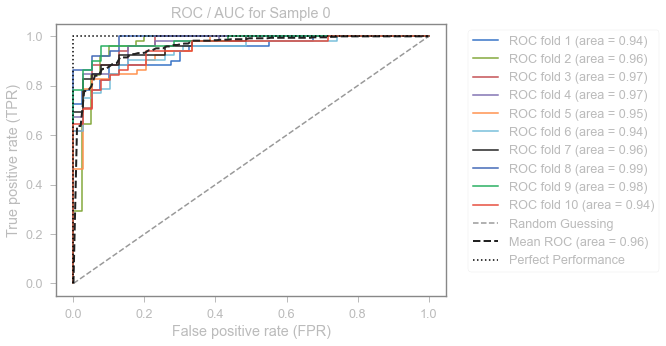

Best parameters for original reduction on Sample 1
0.8886935286935287
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.903, Test Acc.: 0.879
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.912
Fold:  4, Class dist.: [353 463], Train Acc.: 0.901, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.903, Test Acc.: 0.835
Fold:  7, Class dist.: [353 463], Train Acc.: 0.891, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.890, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.867

CV Train accuracy: 0.896 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.886 +/-0.000


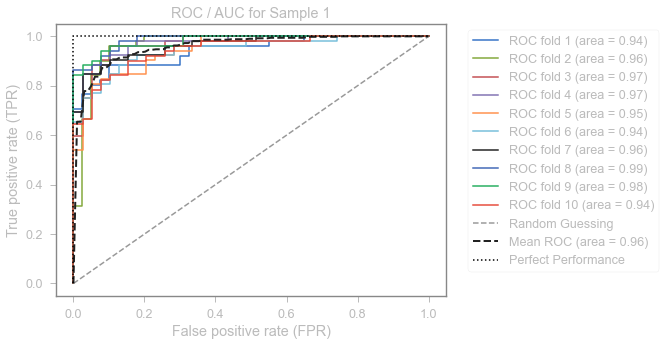

Best parameters for original reduction on Sample 2
0.8644322344322344
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.922, Test Acc.: 0.791
Fold:  2, Class dist.: [352 464], Train Acc.: 0.911, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.919, Test Acc.: 0.901
Fold:  4, Class dist.: [353 463], Train Acc.: 0.919, Test Acc.: 0.846
Fold:  5, Class dist.: [353 463], Train Acc.: 0.926, Test Acc.: 0.835
Fold:  6, Class dist.: [353 463], Train Acc.: 0.926, Test Acc.: 0.857
Fold:  7, Class dist.: [353 463], Train Acc.: 0.915, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.913, Test Acc.: 0.922
Fold:  9, Class dist.: [353 464], Train Acc.: 0.923, Test Acc.: 0.844
Fold: 10, Class dist.: [353 464], Train Acc.: 0.925, Test Acc.: 0.867

CV Train accuracy: 0.925 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.857 +/-0.000


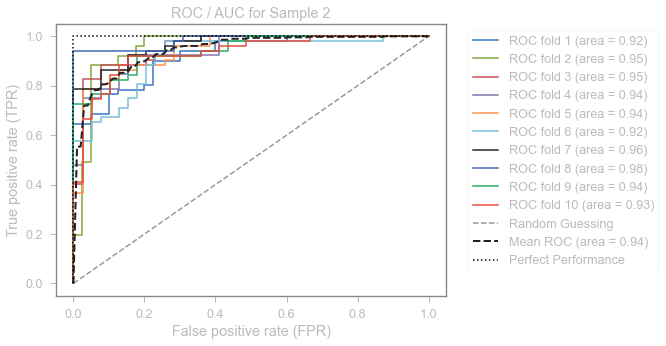

Best parameters for original reduction on Sample 3
0.8666056166056165
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.935, Test Acc.: 0.846
Fold:  2, Class dist.: [352 464], Train Acc.: 0.935, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.930, Test Acc.: 0.879
Fold:  4, Class dist.: [353 463], Train Acc.: 0.935, Test Acc.: 0.857
Fold:  5, Class dist.: [353 463], Train Acc.: 0.939, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.936, Test Acc.: 0.879
Fold:  7, Class dist.: [353 463], Train Acc.: 0.931, Test Acc.: 0.857
Fold:  8, Class dist.: [353 464], Train Acc.: 0.927, Test Acc.: 0.922
Fold:  9, Class dist.: [353 464], Train Acc.: 0.941, Test Acc.: 0.811
Fold: 10, Class dist.: [353 464], Train Acc.: 0.945, Test Acc.: 0.878

CV Train accuracy: 0.945 +/-0.000
CV Test accuracy: 0.878 +/-0.000
CV Test accuracy: 0.800 +/-0.000


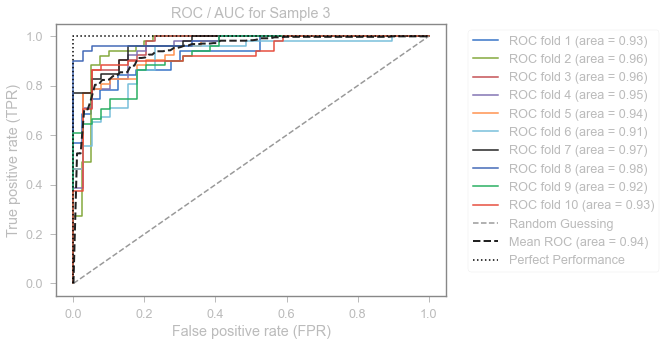

In [22]:
lr_train_accuracies = []
lr_test_accuracies = []
lr_validation_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds, 
                                                yvalidations, samples):
    log_grid_pipeline(xtrs, ytr, xtes, yte, xv, yv, sample)
    log_grid_graph(xtrs, ytr, xtes, yte, sample)
    
    lr_train_accuracies.append(log_grid_pipeline.scores_train)
    lr_test_accuracies.append(log_grid_pipeline.scores_test)
    lr_validation_accuracies.append(log_grid_pipeline.valid_accuracy)

In [23]:
lr_validation_accuracies

[0.8857142857142857, 0.8857142857142857, 0.8571428571428571, 0.8]

# SVC

Here, I follow the same process, but with a Support Vector Model classifier.

This overtrains a little bit, but I think I can control it with some lasso controls.  But honestly, I'm not terribly concerned with this much variability right now.  I'm looking for a performance baseline.

Some observations:

We're talking about marginal gains.  The POSGRU analysis adds about 3% accuracy in this logistic regression.  AMG doesn't really appear to add much value when comparing samples 2 and 3.  Is this significant?

In [24]:
def svc_grid_pipeline(xtrain, ytrain, xtest, ytest, xvalid, yvalid, sample):
    
    pipe_svc = make_pipeline(SVC(random_state = 0))

    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                 {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

    
    gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(xtrain, ytrain)
    print('The best score and parameters, and overall accuracy for '+sample+' are:\n')
    print(gs.best_score_)
    print(gs.best_params_)
    
    pipe_svc = make_pipeline(SVC(kernel = gs.best_params_['svc__kernel'],C = gs.best_params_['svc__C'], random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    
    for k, (train, test) in enumerate(kfold):
        pipe_svc.fit(xtrain[train], ytrain[train])
        score_train = pipe_svc.score(xtrain[train], ytrain[train])
        score_test = pipe_svc.score(xtrain[test], ytrain[test])
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    svc_grid_pipeline.train_accuracies = np.mean(score_train)
    svc_grid_pipeline.test_accuracies = np.mean(score_test)
    
    X_valid_hat = pipe_svc.predict(xvalid)
        
    valid_correct = (X_valid_hat == yvalid)
    valid_accuracy = valid_correct.sum() / valid_correct.size
    svc_grid_pipeline.valid_accuracy = valid_correct.sum() / valid_correct.size
    
    
    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))
    print('CV Validation accuracy: %.3f +/-%.3f'%(np.mean(valid_accuracy), np.std(valid_accuracy)))
    print('\n')


In [25]:
svc_train_accuracies = []
svc_test_accuracies = []
svc_validation_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, 
                                                Xvalidationscaleds, yvalidations, samples):
    svc_grid_pipeline(xtrs, ytr, xtes, yte, xv, yv, sample)
    
    svc_train_accuracies.append(svc_grid_pipeline.train_accuracies)
    svc_test_accuracies.append(svc_grid_pipeline.test_accuracies)
    svc_validation_accuracies.append(svc_grid_pipeline.valid_accuracy)

The best score and parameters, and overall accuracy for Sample 0 are:

0.8831746031746033
{'svc__C': 100.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.902, Test Acc.: 0.901
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.901
Fold:  3, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.890
Fold:  4, Class dist.: [353 463], Train Acc.: 0.897, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.835
Fold:  6, Class dist.: [353 463], Train Acc.: 0.909, Test Acc.: 0.813
Fold:  7, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.901
Fold:  8, Class dist.: [353 464], Train Acc.: 0.898, Test Acc.: 0.900
Fold:  9, Class dist.: [353 464], Train Acc.: 0.886, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.898, Test Acc.: 0.856

CV Train accuracy: 0.898 +/-0.000
CV Test accuracy: 0.856 +/-0.000
CV Validation accuracy: 0.886 +/-0.000


The best score and parameters, and overall accuracy for Sa

# Decision Trees

I did a Random Forest / Decision Tree classifier just because Young, et.al. used one, but I generally find them to be more useful for EDA than for good predictive power, even though they do show you feature names.

With such comparatively poor performance, I question their applicability to this dataset.

Here, I've eliminated the scaled df.  All I really need is the headers.  Maybe get this back.

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

gs_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                     param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}],
                     scoring = 'accuracy',
                     cv = 5)

max_depths = []

# Xtrainscaled_dfs = [X0_train_scaled_df, X1_train_scaled_df, X2_train_scaled_df, X3_train_scaled_df]

dt_train_accuracies = []
dt_test_accuracies = []
dt_val_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample, xtrdfs in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds,
                                                        yvalidations, samples, train_dfs):

    gs_dtf = gs_dt.fit(xtrs, ytr)
    
    print(sample+'\n')

    print(gs_dtf.best_score_)
    print(gs_dtf.best_params_)
    max_depths.append(list(gs_dtf.best_params_.values())[0])

    train_scores = cross_val_score(gs_dtf, xtrs, ytr, scoring = 'accuracy', cv = 15)
    test_scores = cross_val_score(gs_dtf, xtes, yte, scoring = 'accuracy', cv = 15)
    val_scores = cross_val_score(gs_dtf, xv, yv, scoring = 'accuracy', cv = 3)
    
    dt_train_accuracies.append(np.mean(train_scores))
    dt_test_accuracies.append(np.mean(test_scores))
    dt_val_accuracies.append(np.mean(val_scores))

    print('CV train accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(train_scores), np.std(train_scores)))
    print('CV test accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(test_scores), np.std(test_scores)))
    print('CV val accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(val_scores), np.std(val_scores)))
    print('\n')

Sample 0

0.8125736142310729
{'max_depth': 4}
CV train accuracy with Decision Tree classifier: 0.819 +/- 0.060
CV test accuracy with Decision Tree classifier: 0.761 +/- 0.103
CV val accuracy with Decision Tree classifier: 0.886 +/- 0.103


Sample 1

0.8092769109343696
{'max_depth': 4}
CV train accuracy with Decision Tree classifier: 0.811 +/- 0.060
CV test accuracy with Decision Tree classifier: 0.752 +/- 0.108
CV val accuracy with Decision Tree classifier: 0.886 +/- 0.103


Sample 2

0.7353469734685204
{'max_depth': 3}
CV train accuracy with Decision Tree classifier: 0.713 +/- 0.042
CV test accuracy with Decision Tree classifier: 0.686 +/- 0.100
CV val accuracy with Decision Tree classifier: 0.634 +/- 0.135


Sample 3

0.7375569182199015
{'max_depth': 3}
CV train accuracy with Decision Tree classifier: 0.716 +/- 0.041
CV test accuracy with Decision Tree classifier: 0.656 +/- 0.092
CV val accuracy with Decision Tree classifier: 0.659 +/- 0.059




This just doesn't do a great job.  Fewer PI (no POSGRU differentiation) performs best, but it's not particulary great comparatively.


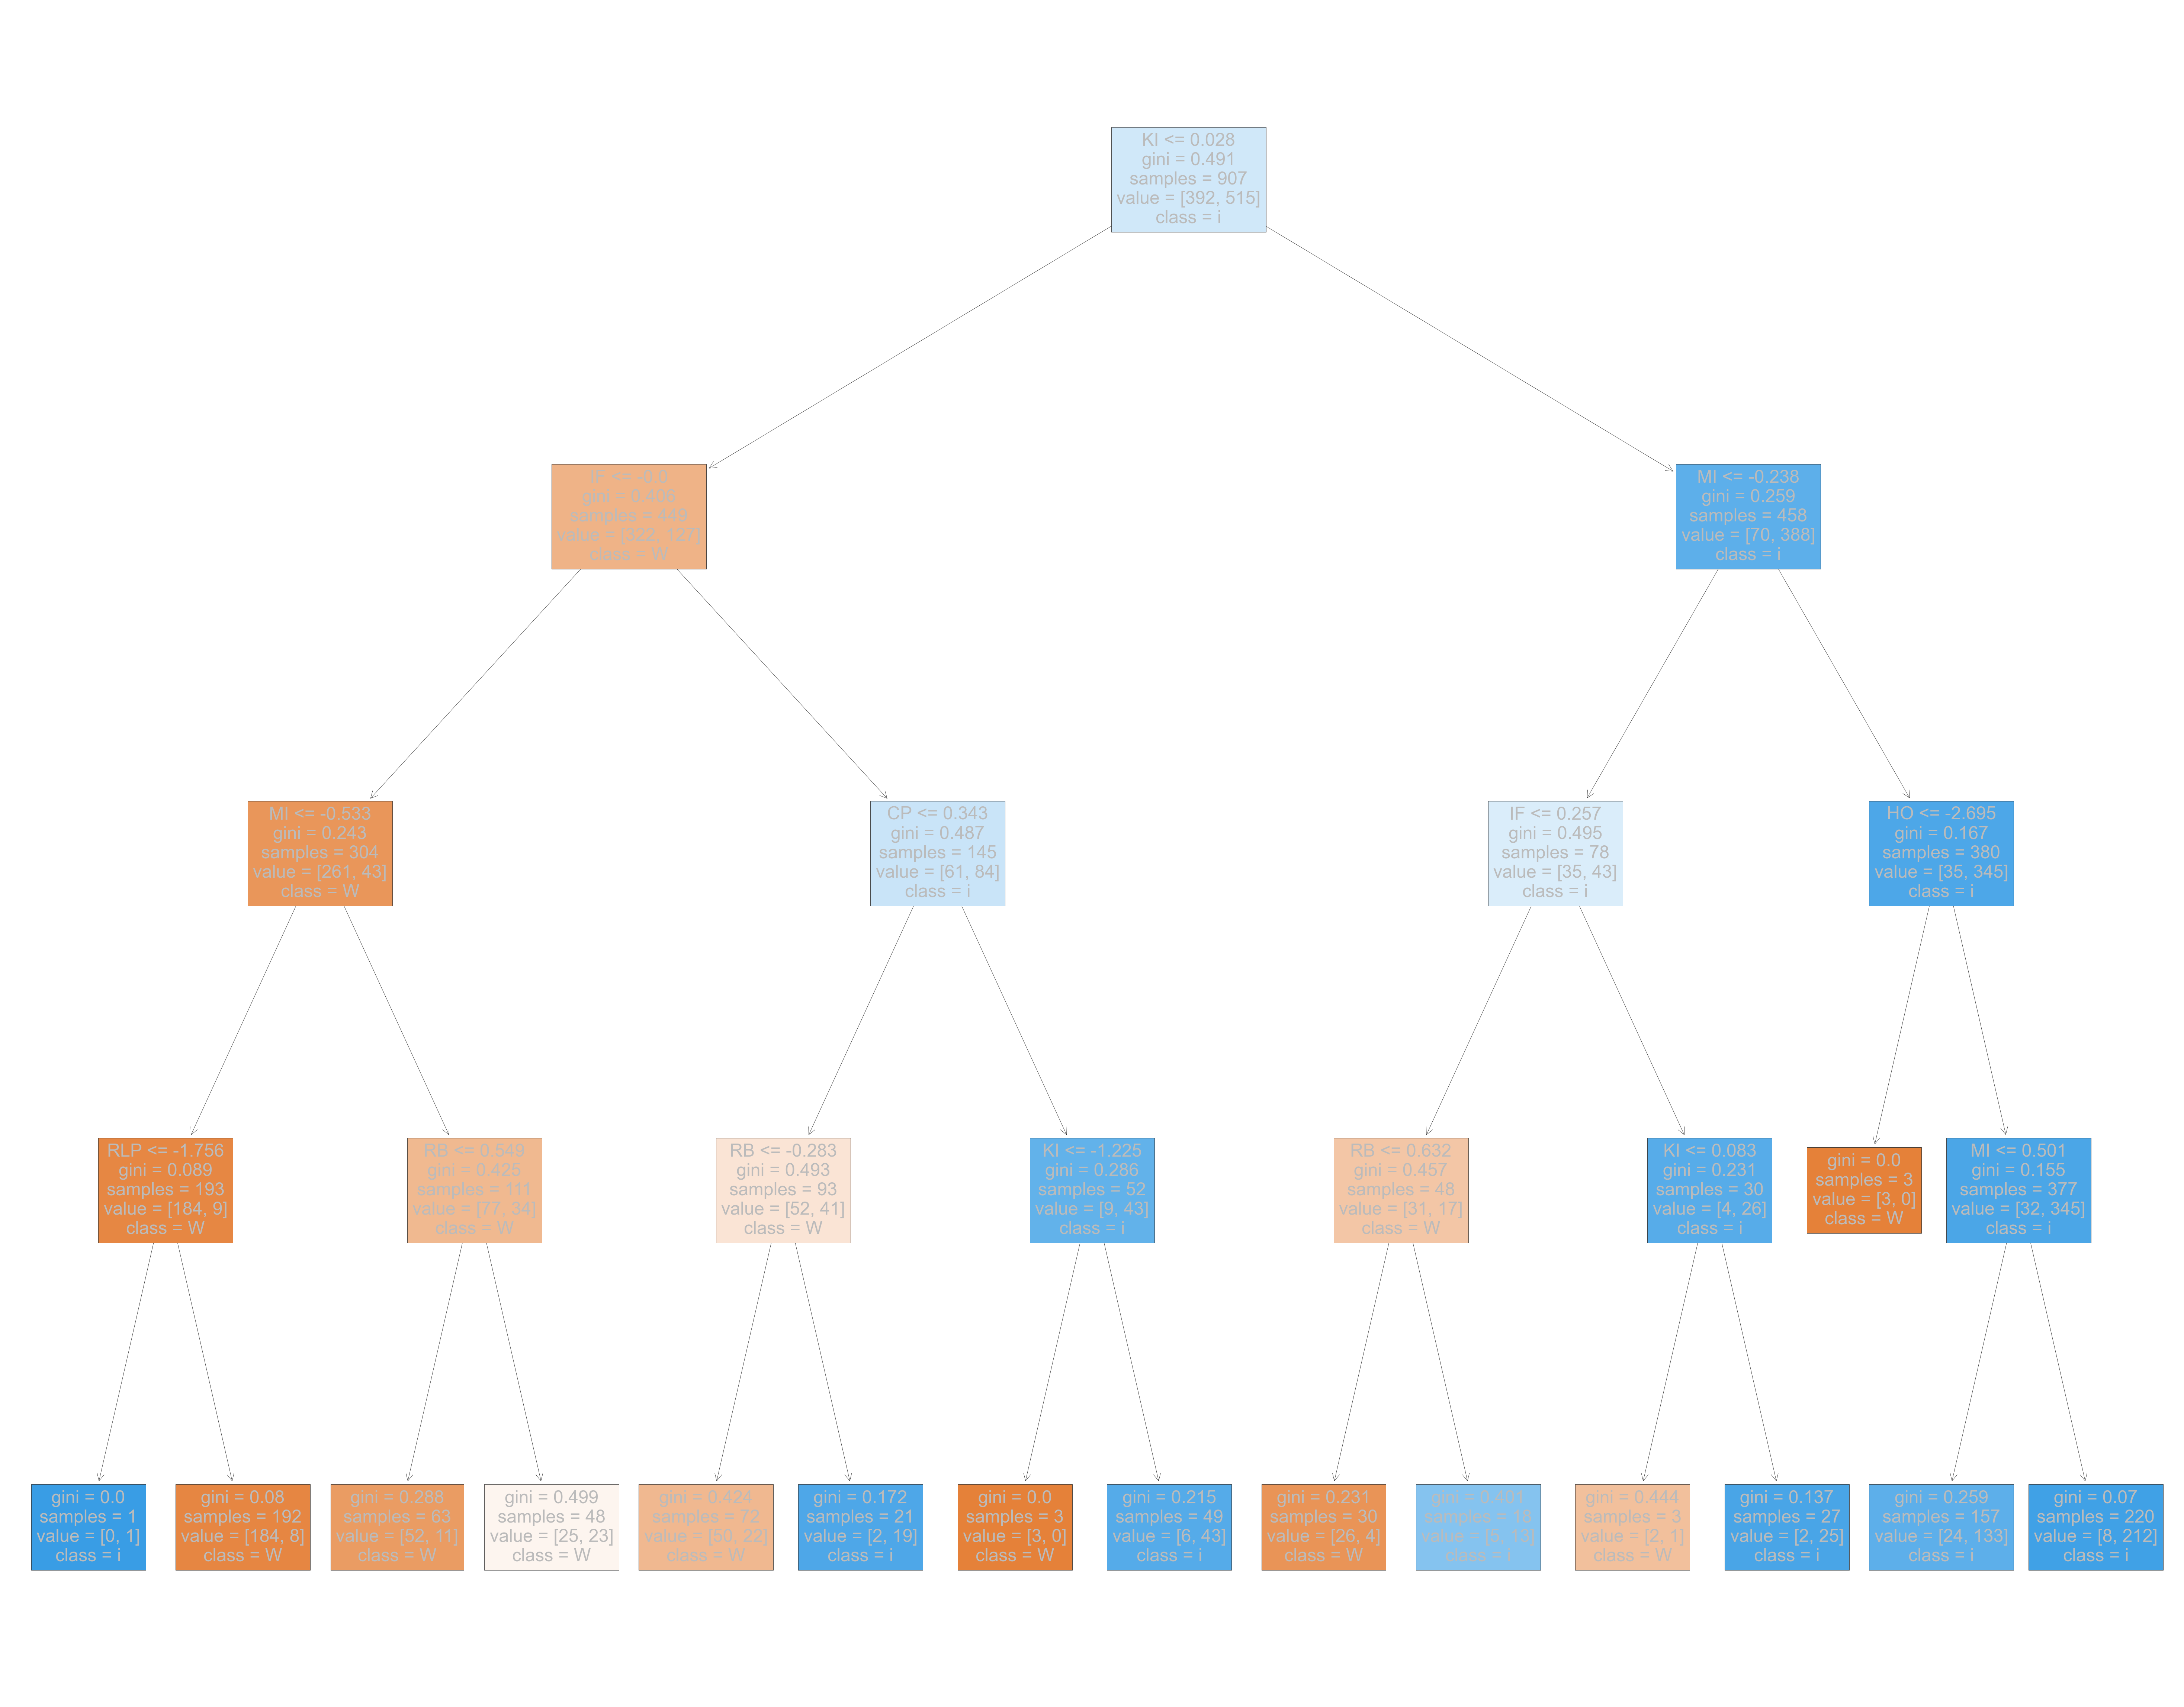

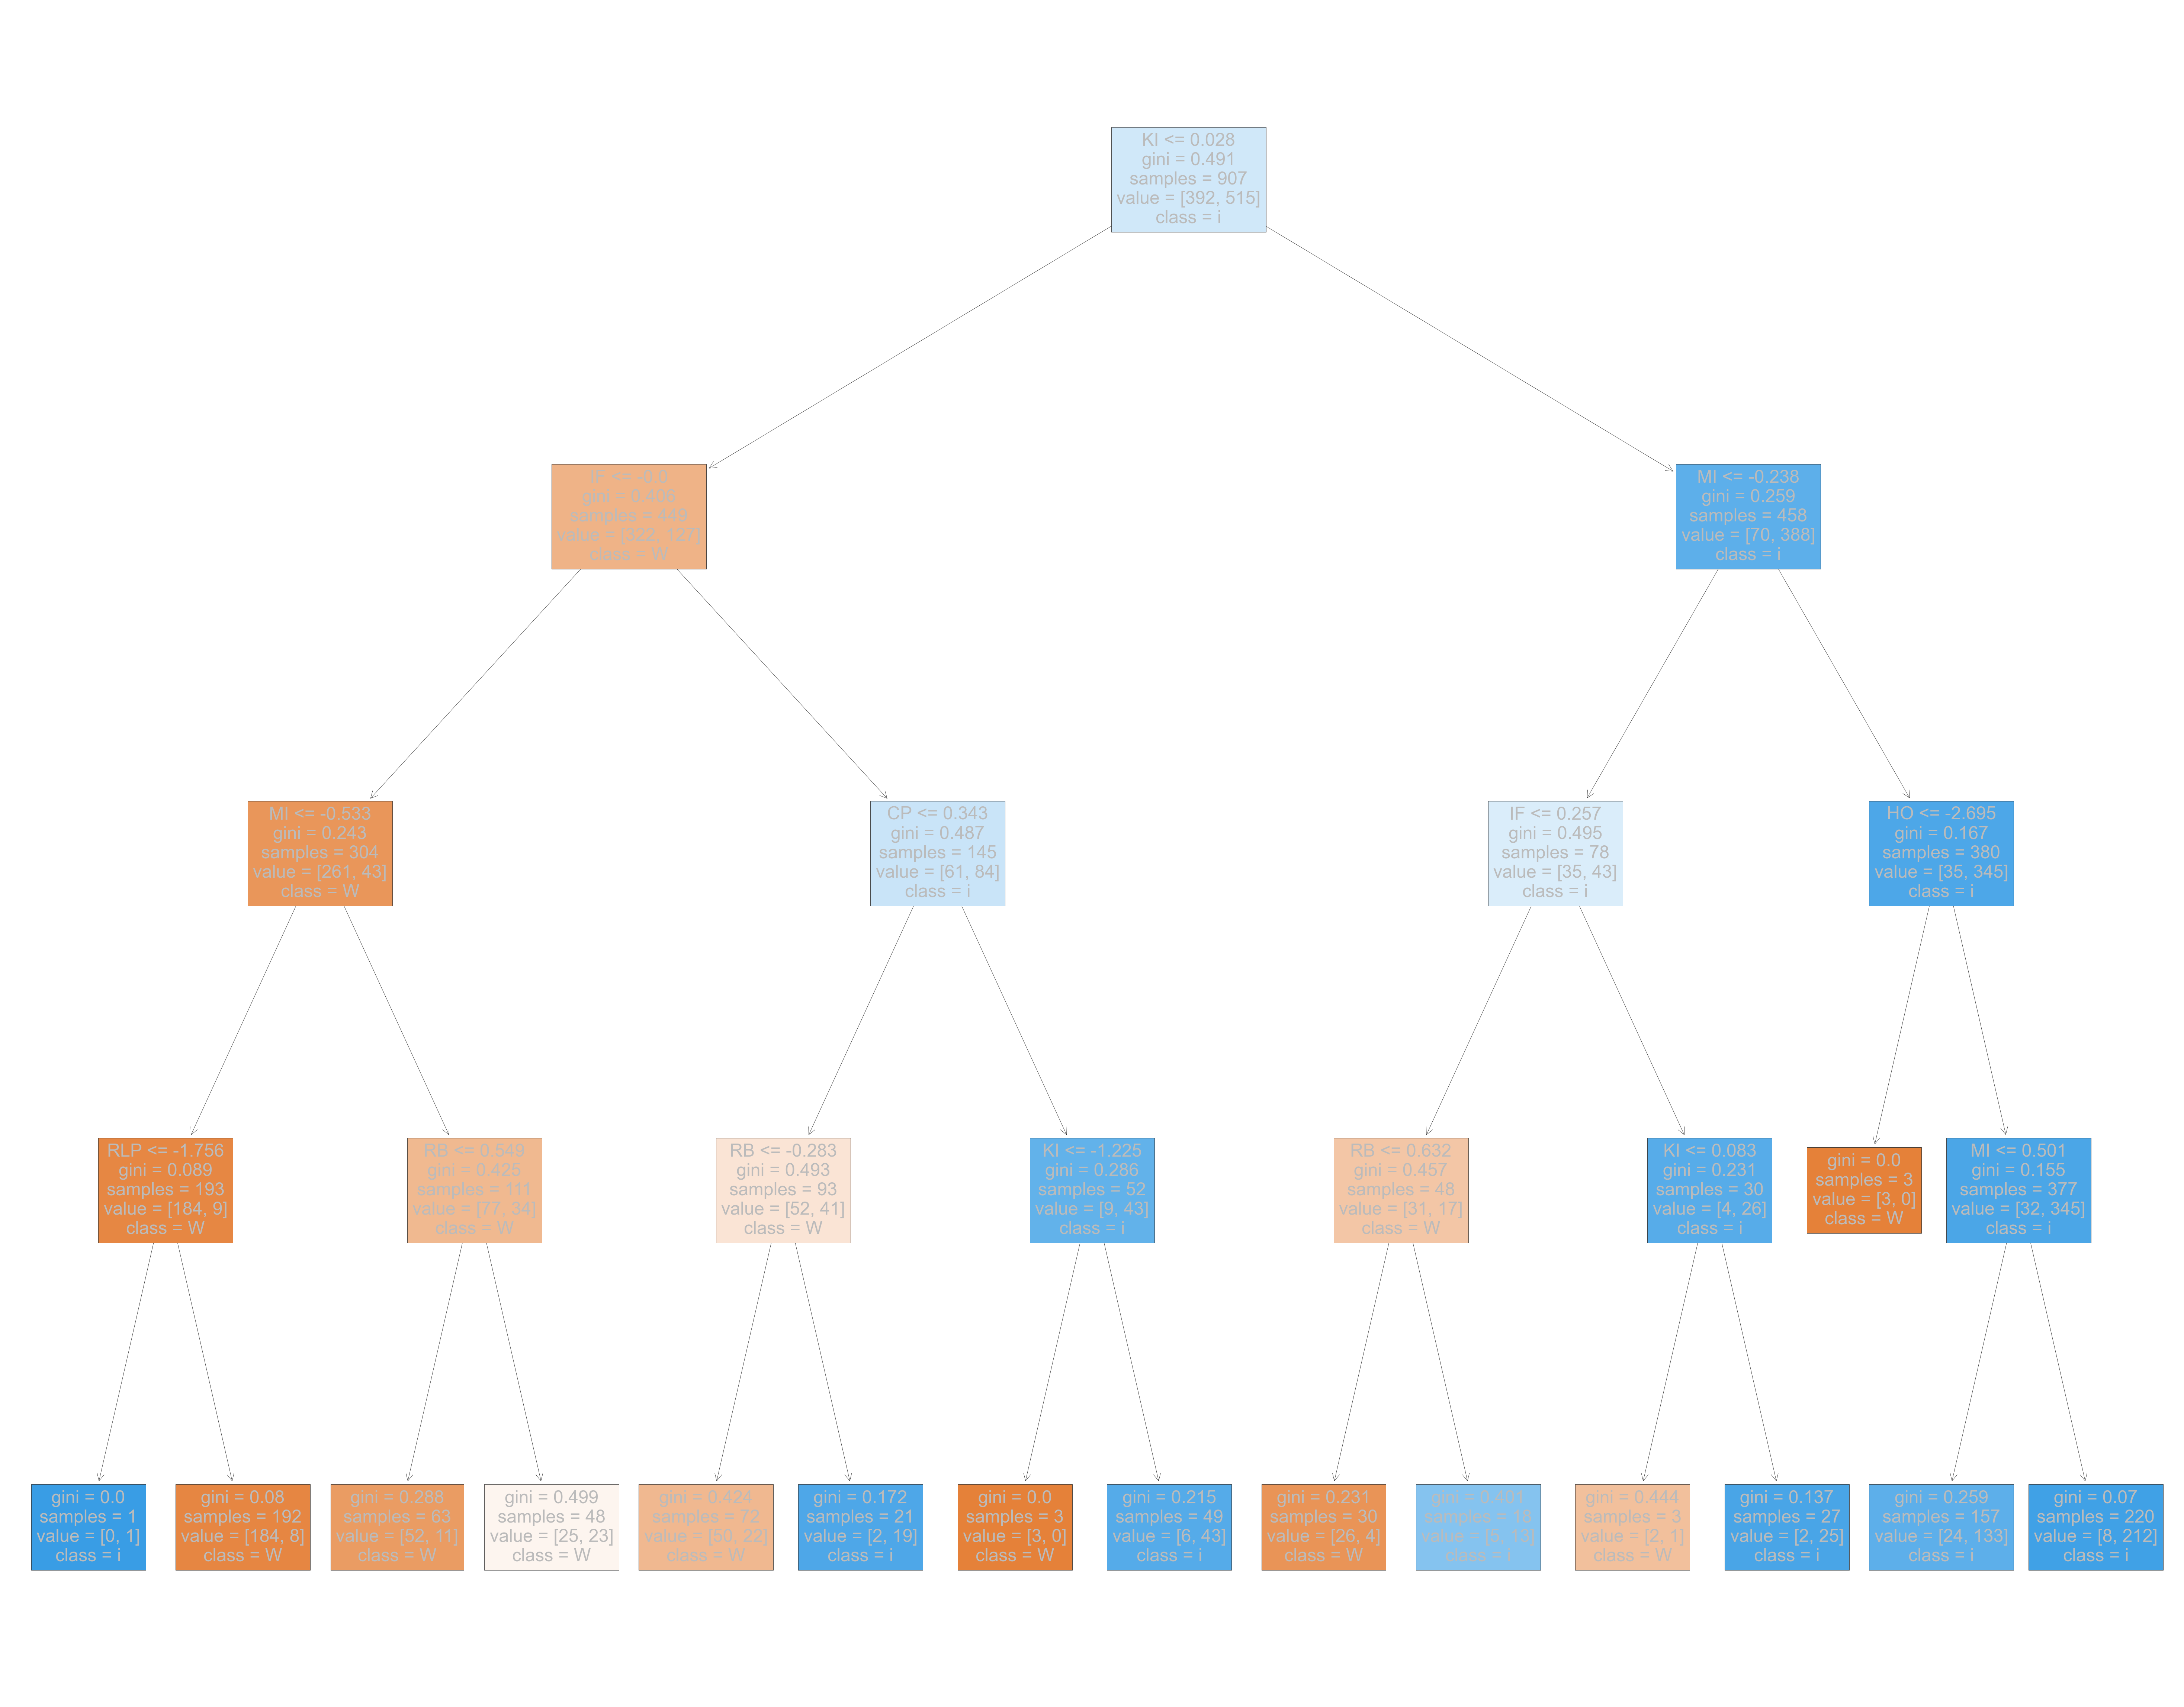

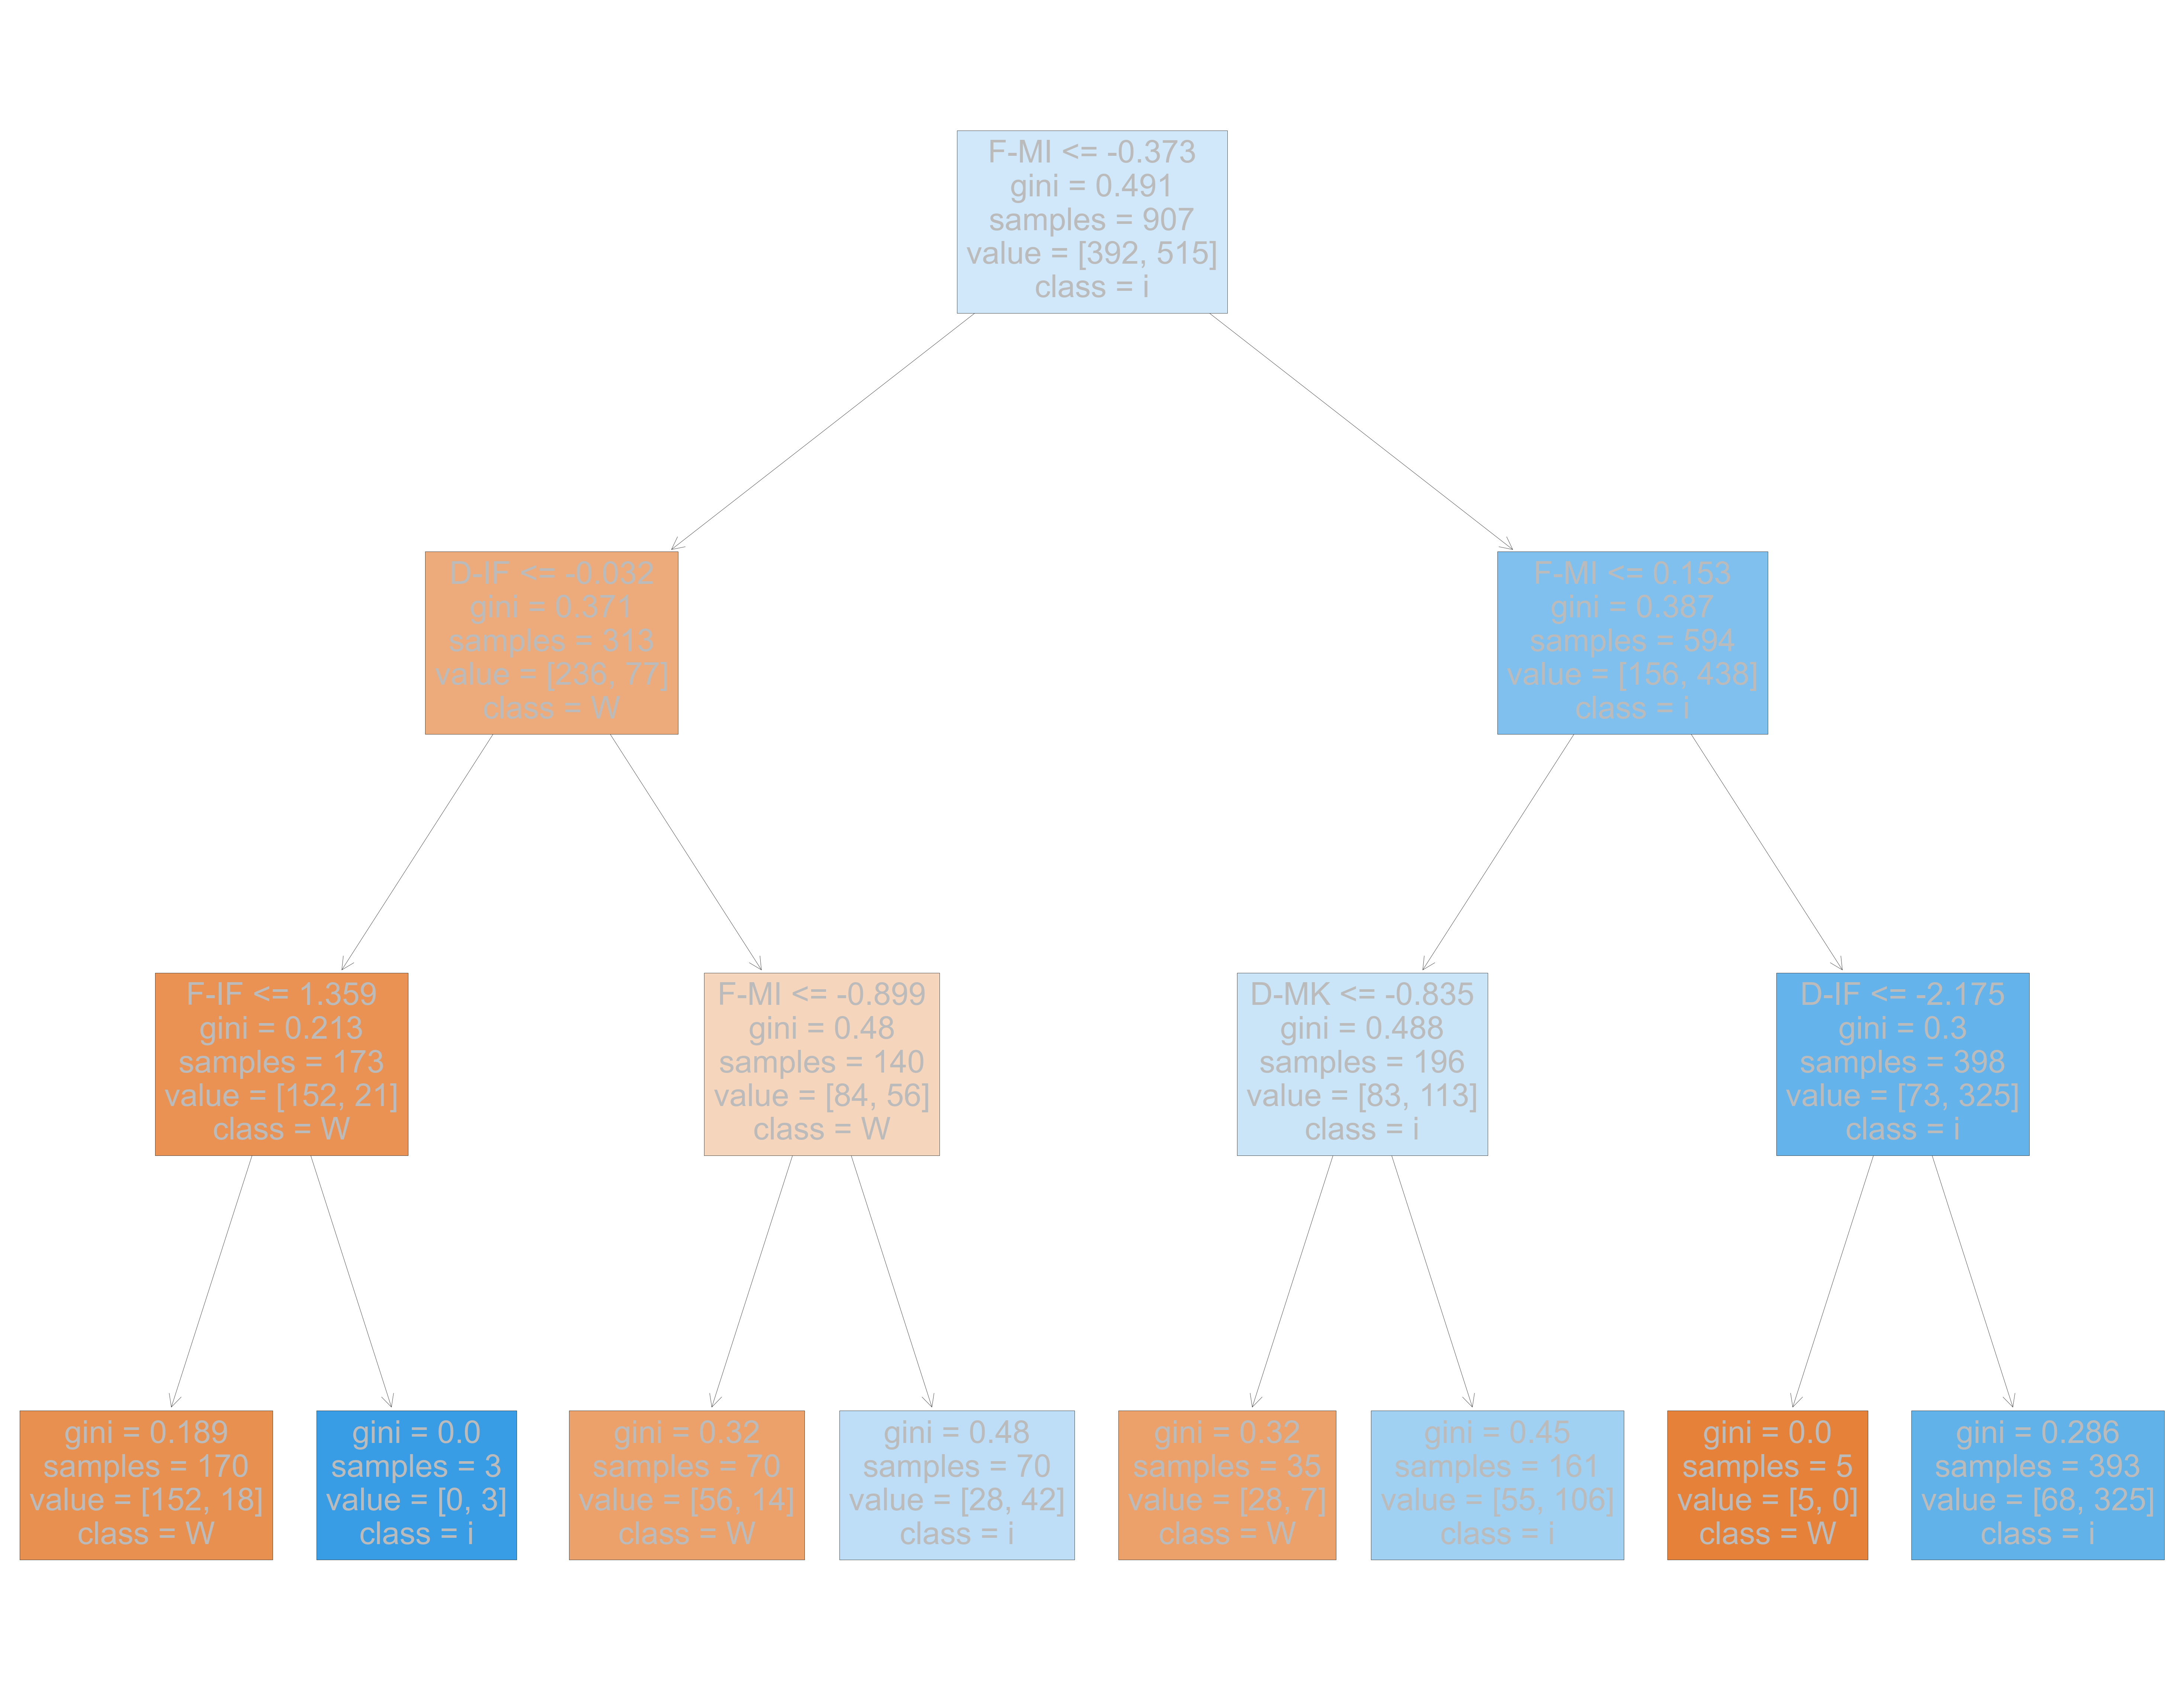

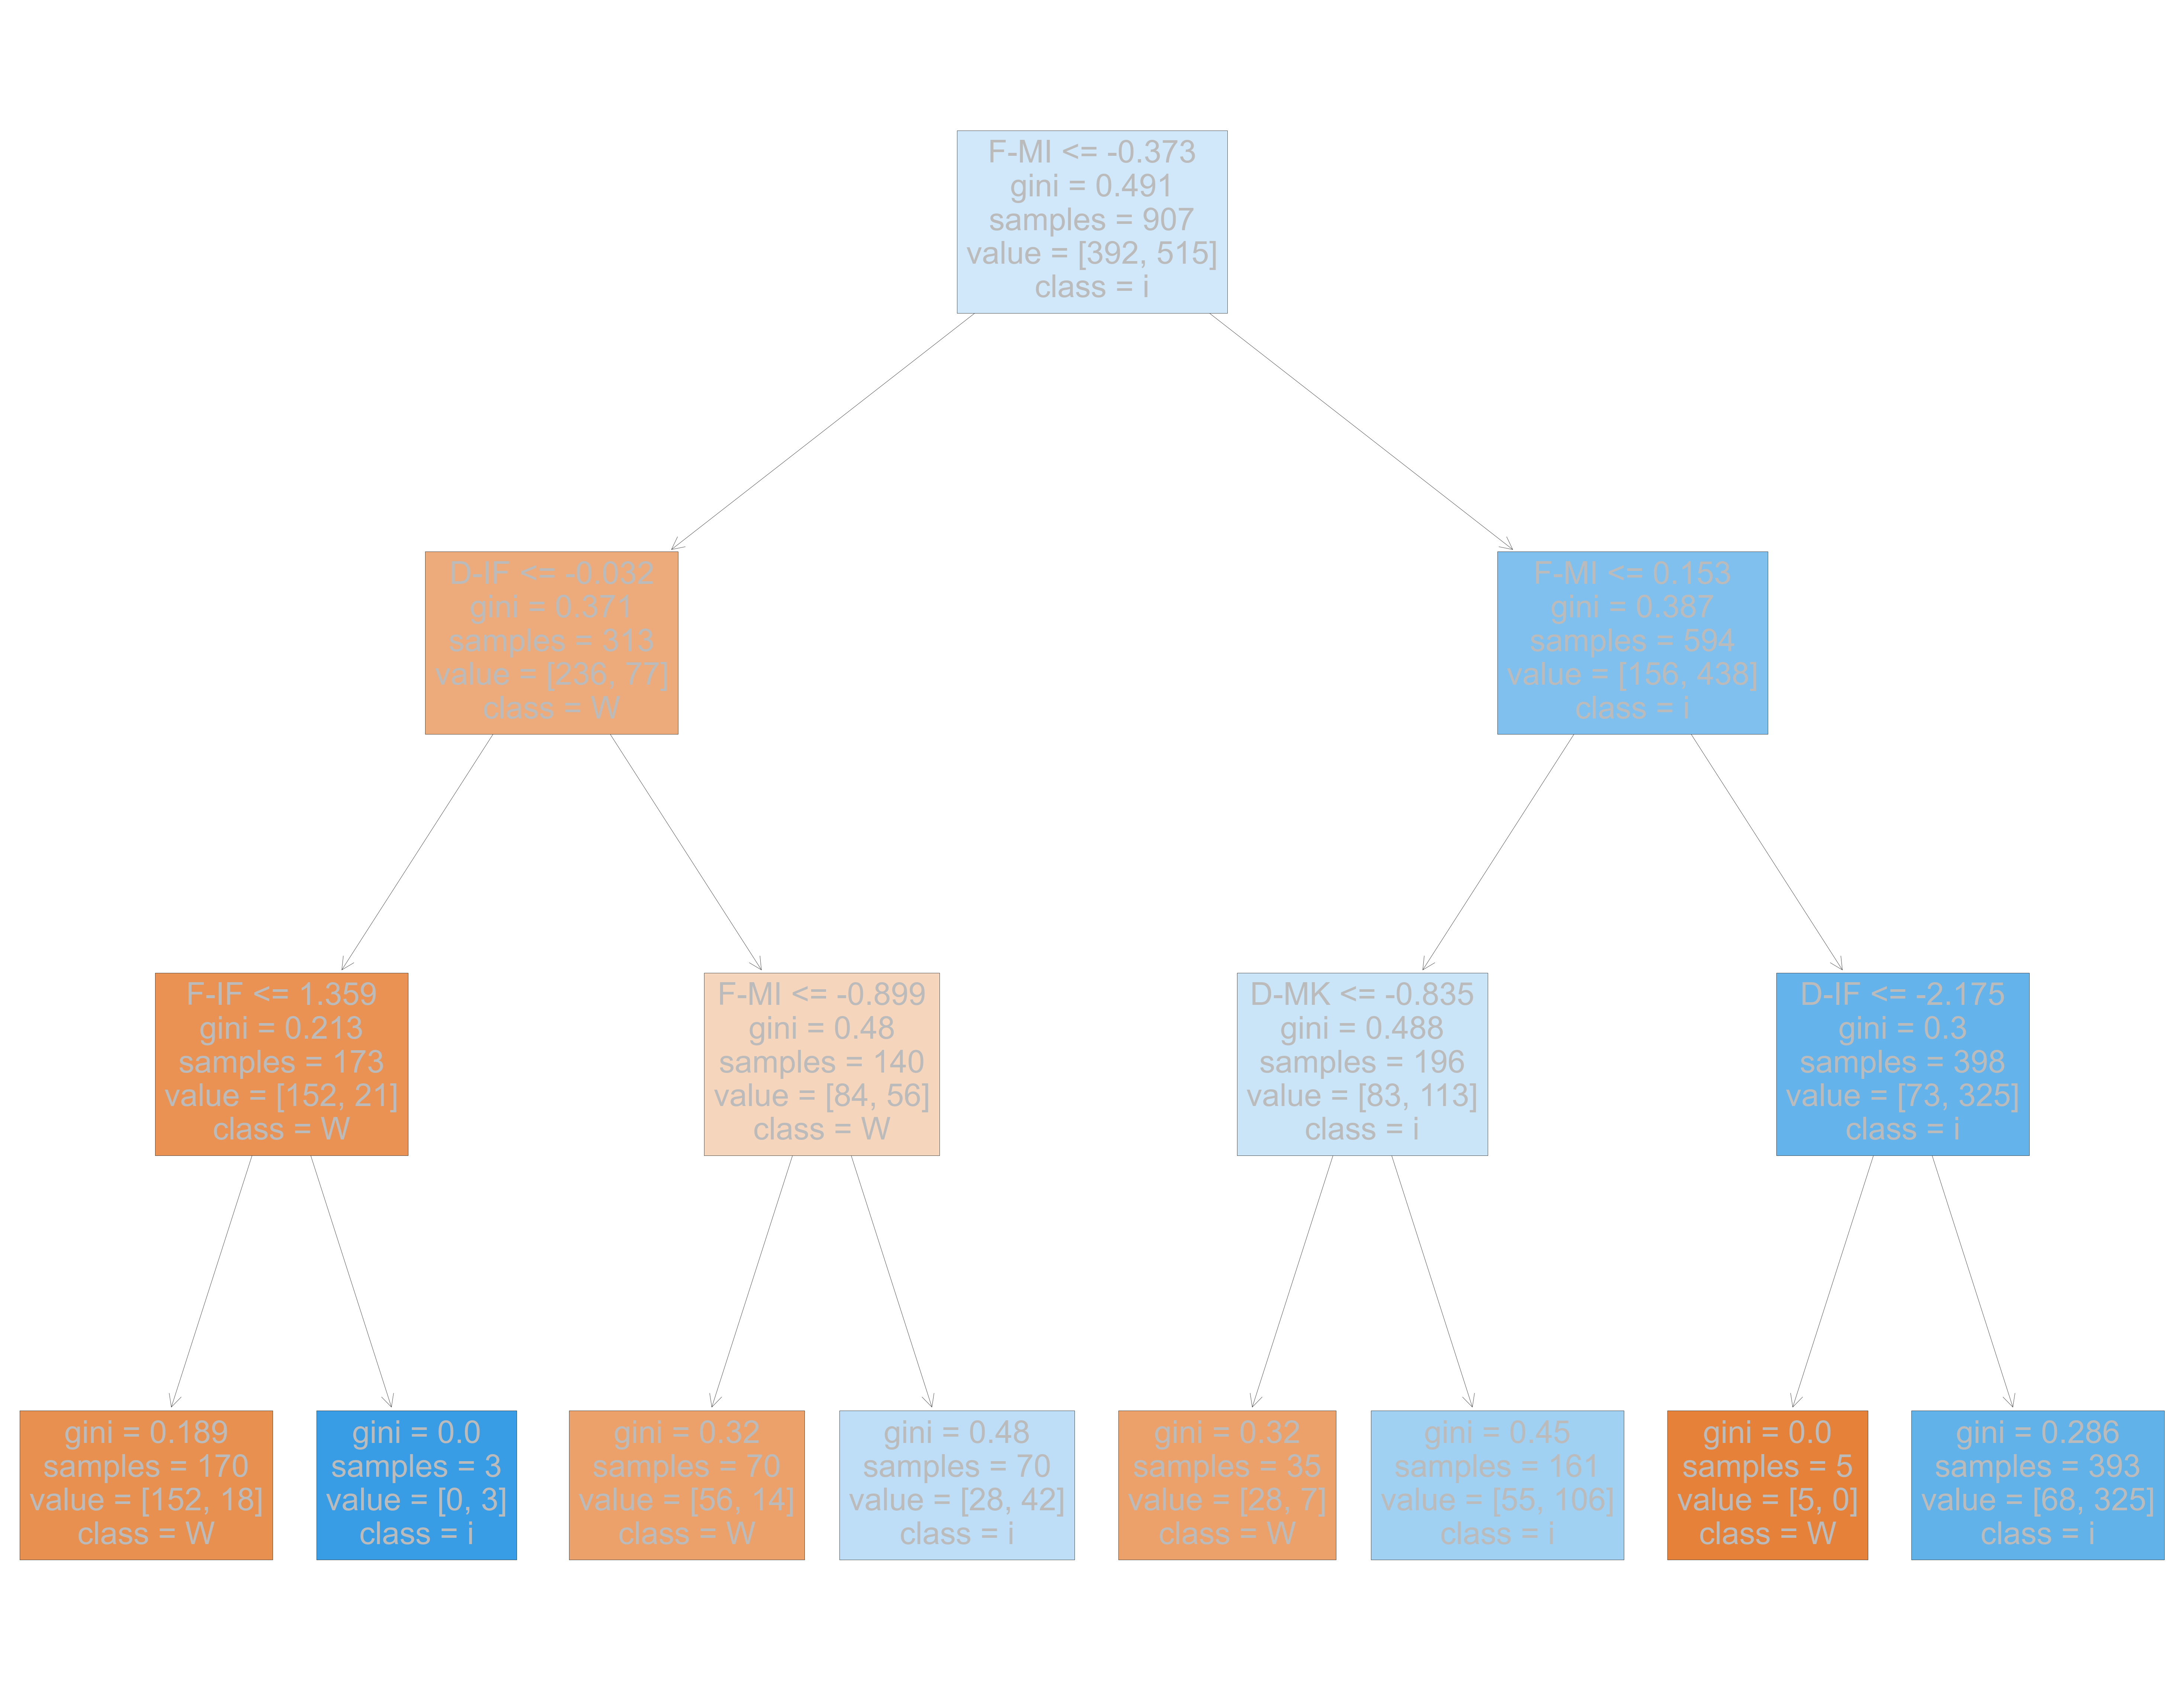

In [27]:
from sklearn import tree



for xtrs, ytr, xtes, yte, sample, xtrdfs, md in zip(Xtrainscaleds, ytrains, Xtestscaleds, 
                                                ytests, samples, train_dfs, max_depths):
    clf = DecisionTreeClassifier(max_depth = md)

    clf.fit(xtrs, ytr)
    cn = xtrdfs.columns.to_list()
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,20), dpi=300)
    plt.title('Decision Tree plot for '+sample)
    tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);

    fig.savefig(sample+'.png')

# Random Forest Classifier

Sample 0 test accuracy is:  0.8105726872246696
Sample 0 validation accuracy is:  0.8285714285714286
Sample 0 ROC_AUC value =  0.8913937668090491
   Feature  Importance
2       KI    0.149338
16      MI    0.138619
8       IF    0.100563
1       DI    0.069046
13      CP    0.067657
14      UP    0.053142
3       MK    0.051041
0      RLP    0.050770
7       RB    0.038102
10      CG    0.037609


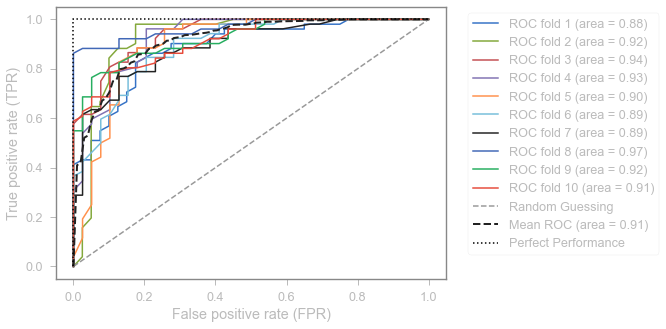

Sample 1 test accuracy is:  0.8105726872246696
Sample 1 validation accuracy is:  0.8857142857142857
Sample 1 ROC_AUC value =  0.8866872330327479
   Feature  Importance
16      MI    0.142316
2       KI    0.137585
1       DI    0.086125
8       IF    0.081340
13      CP    0.067753
14      UP    0.047767
3       MK    0.047468
0      RLP    0.045180
19     AMG    0.039004
10      CG    0.038431


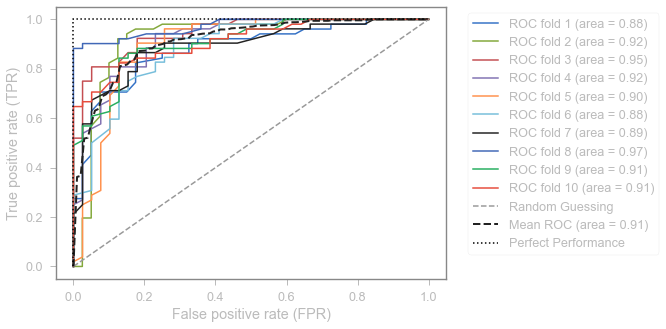

Sample 2 test accuracy is:  0.7929515418502202
Sample 2 validation accuracy is:  0.7428571428571429
Sample 2 ROC_AUC value =  0.8602278120550546
    Feature  Importance
37     F-MI    0.089275
29     F-IF    0.036682
0       RLP    0.034370
92  HDAF-TM    0.027685
85  HFAD-TM    0.024101
2      D-KI    0.023462
50     M-IF    0.021800
42    F-Age    0.020339
14     D-UP    0.020184
23     F-KI    0.020005


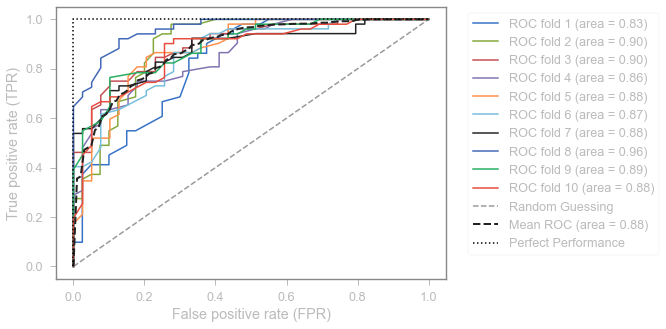

Sample 3 test accuracy is:  0.7841409691629956
Sample 3 validation accuracy is:  0.7714285714285715
Sample 3 ROC_AUC value =  0.853781047302642
     Feature  Importance
38      F-MI    0.092052
30      F-IF    0.035816
0        RLP    0.031059
96   HDAF-TM    0.028441
2       D-KI    0.025533
52      M-IF    0.022361
89   HFAD-TM    0.021696
25      F-MK    0.021430
95  HFAD-Age    0.019575
44     F-Age    0.018684


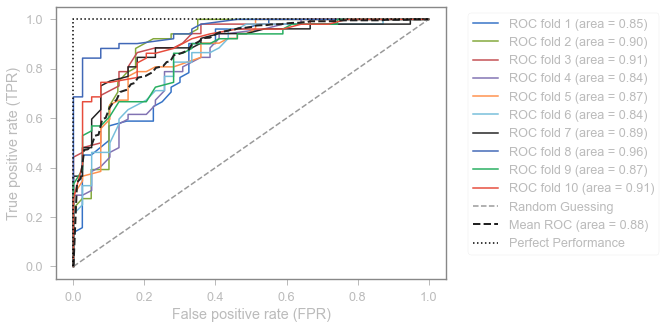

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


rf_importance_dfs = []

rf_test_accuracies = []
rf_val_accuracies = []

for xtr, xte, ytr, yte, xv, yv, samp, xts in zip(Xtrainscaleds, Xtestscaleds, ytrains, ytests, Xvalidationscaleds,
                                                 yvalidations, samples, train_dfs):

    model = RandomForestClassifier(n_estimators = 100, bootstrap = True)

    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    probas = model.predict_proba(xte)[:,1]

    val_predictions = model.predict(xv)
    val_probas = model.predict_proba(xv)[:,1]
    
    
    test_accuracy = accuracy_score(yte, predictions)
    rf_test_accuracies.append(test_accuracy)
    
    val_accuracy = accuracy_score(yv, val_predictions)
    rf_val_accuracies.append(val_accuracy)

    roc_value = roc_auc_score(yte, probas)

    print(samp+' test accuracy is: ',test_accuracy)
    print(samp+' validation accuracy is: ',val_accuracy)
    print(samp+' ROC_AUC value = ',roc_value)
    key_features = pd.DataFrame({'Feature': list(xts.columns),
                                'Importance': model.feature_importances_}).sort_values('Importance', ascending = False)
    print(key_features.head(10))
    rf_importance_dfs.append(key_features)
    
    kfold = StratifiedKFold(n_splits = 10).split(xtr, ytr)
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = model.fit(xtr[train], ytr[train]).predict_proba(xtr[test])
        fpr, tpr, thresholds = roc_curve(ytr[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


# XGboost

In [29]:
# pip install xgboost

In [30]:
# from sklearn import datasets
import xgboost as xgb

In [31]:
# It works on arrays, not DataFrames

D_trains = []
D_tests = []

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    
    D_train = xgb.DMatrix(xtrs, label = ytr)
    D_test = xgb.DMatrix(xtes, label = yte)
    
    D_trains.append(D_train)
    D_tests.append(D_test)

In [32]:
param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 2}

steps = 20

In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

xgboost_test_accuracies = []

for n in range(4):
    xgb_model = xgb.train(param, D_trains[n], steps)

    test_preds = xgb_model.predict(D_tests[n])
    best_test_preds = np.asarray([np.argmax(line) for line in test_preds])
    
    print('Results for : '+samples[n])
    print('Precision = {}'.format(precision_score(ytests[n], best_test_preds, average = 'macro')))
    print('Recall = {}'.format(recall_score(ytests[n], best_test_preds, average = 'macro')))
    print('Accuracy = {}'.format(accuracy_score(ytests[n], best_test_preds)))
    print('\n')
    
    xgboost_test_accuracy = accuracy_score(ytests[n], best_test_preds)
    
    xgboost_test_accuracies.append(xgboost_test_accuracy)

Results for : Sample 0
Precision = 0.8246554963983714
Recall = 0.8279939882929916
Accuracy = 0.8281938325991189


Results for : Sample 1
Precision = 0.8424485305673425
Recall = 0.8447239360860623
Accuracy = 0.8458149779735683


Results for : Sample 2
Precision = 0.7774939172749392
Recall = 0.7706454674893213
Accuracy = 0.7797356828193832


Results for : Sample 3
Precision = 0.7757633587786259
Recall = 0.7743236829615567
Accuracy = 0.7797356828193832




In [34]:
# Pre-grid search

from xgboost import XGBClassifier

XGB_test_accuracies = []
XGB_val_accuracies = []

for n in range(4):
#     xgb_model = xgb.train(param, D_trains[n], steps)

    XGB_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
    XGB_model.fit(Xtrainscaleds[n], ytrains[n])
    
    predictions = XGB_model.predict(Xtestscaleds[n])
    accuracy = accuracy_score(ytests[n], predictions)
    print('Test Accuracy: %.2f%%'%(accuracy))
    XGB_test_accuracies.append(accuracy)
    
    val_predictions = XGB_model.predict(Xvalidationscaleds[n])
    val_accuracy = accuracy_score(yvalidations[n], val_predictions)
    print('Validation Accuracy: %.2f%%'%(val_accuracy))
    XGB_val_accuracies.append(val_accuracy)

    


Test Accuracy: 0.84%
Validation Accuracy: 0.94%
Test Accuracy: 0.85%
Validation Accuracy: 0.89%
Test Accuracy: 0.78%
Validation Accuracy: 0.80%
Test Accuracy: 0.80%
Validation Accuracy: 0.83%


# Multilayer Perceptron

I wanted to establish a baseline with the NeuralNet MLP from Rauschka, the first NeuralNet that I had ever used.

In [35]:
from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py'
urlretrieve(url, 'neuralnet.py')

from neuralnet import NeuralNetMLP

Here, the hyperparameters are very clear and visible.  We can't do a grid search with this classifier, so I manipulated these hyperparameters a little bit manually, trying, unsuccessfully, to reduce loss.

I did not create a validation subset inside of the training data.  Validation  = the test data set.

In [36]:
nn = NeuralNetMLP(n_hidden = 10,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [37]:
def neural_network(xtrain, xtest, ytrain, ytest, sample):
    
    nn.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn.epochs), nn.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn.epochs), nn.eval_['train_acc'], label = 'training')
    plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network.train_accuracy = nn.eval_['train_acc'][-1]
    neural_network.test_accuracy = nn.eval_['valid_acc'][-1]
    plt.show()

In [38]:
nn2 = NeuralNetMLP(n_hidden = 75,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [39]:
def neural_network2(xtrain, xtest, ytrain, ytest, sample):
    
    nn2.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn2.epochs), nn2.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn2.epochs), nn2.eval_['train_acc'], label = 'training')
    plt.plot(range(nn2.epochs), nn2.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network2.train_accuracy = nn2.eval_['train_acc'][-1]
    neural_network2.test_accuracy = nn2.eval_['valid_acc'][-1]
    plt.show()

200/200 | Cost: 428.28 | Train/Valid Acc.: 89.75%/89.43%  

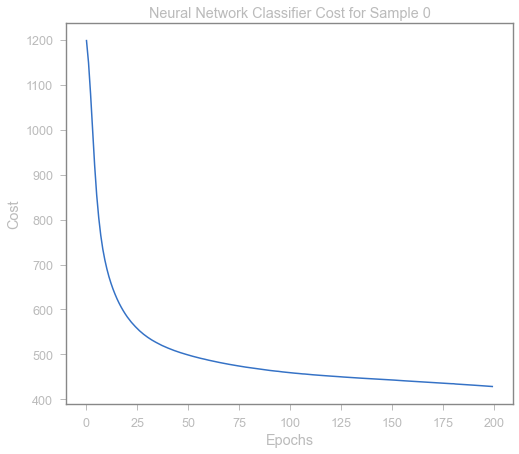

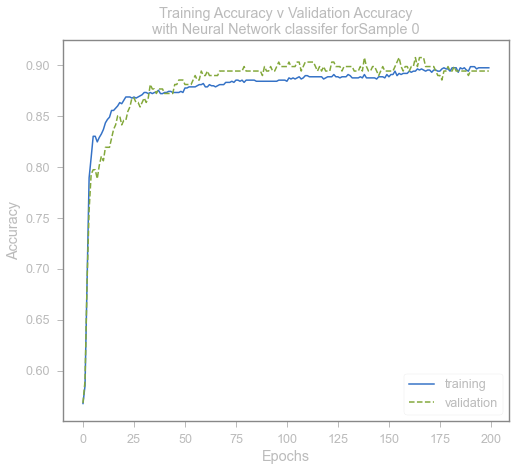

200/200 | Cost: 419.10 | Train/Valid Acc.: 90.41%/89.43%  

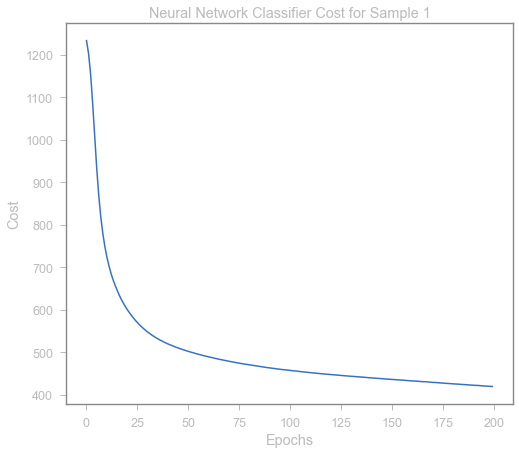

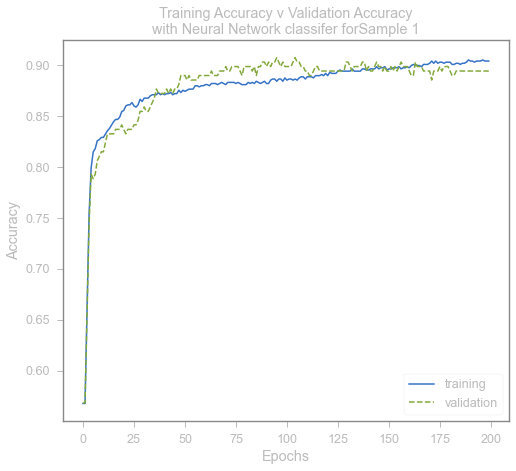

200/200 | Cost: 82.45 | Train/Valid Acc.: 99.89%/87.22%   

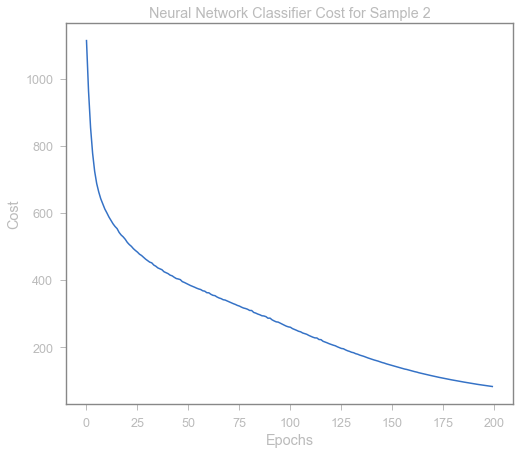

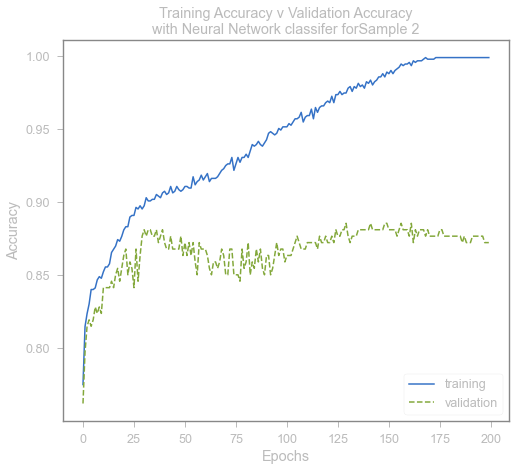

200/200 | Cost: 77.56 | Train/Valid Acc.: 99.89%/87.22%   

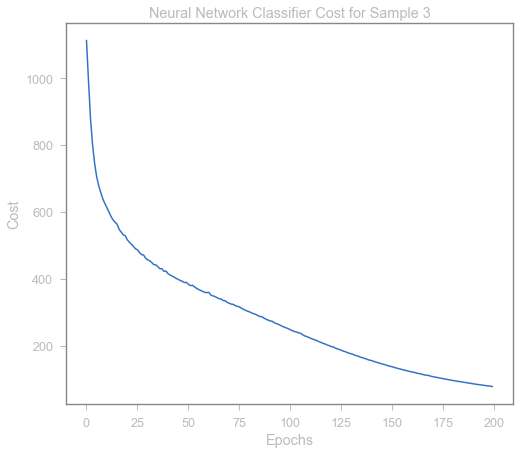

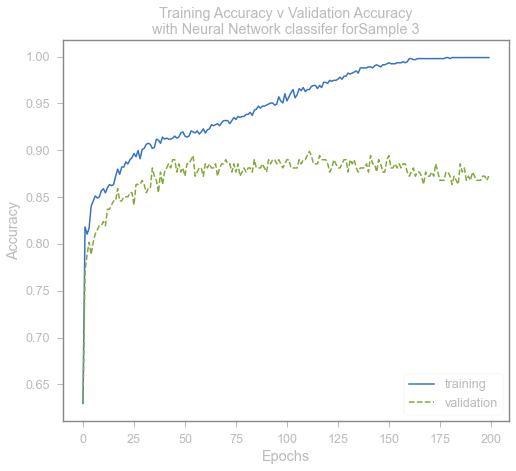

In [40]:
nn_train_accuracies = []
nn_test_accuracies = []



for n in range(4):
    
    if n < 2:
        neural_network(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network.train_accuracy)
        nn_test_accuracies.append(neural_network.test_accuracy)
    else:
        neural_network2(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network2.train_accuracy)
        nn_test_accuracies.append(neural_network2.test_accuracy)

    

# TensorFlow setup

Everything that I've done so far was on my initial, "regular dataset".  I cut it up and put it back together, a bunch of times, but at least I have everything normalized the way I want with the  fit.

But, let's scrap that and start fresh with TensorFlow on my smallest dataframe possible, whatever we wind up with.

Essentially, I am using a TensorFlow tutorial (https://www.tensorflow.org/tutorials/keras/regression) to start fresh with a new, un-normalized dataframe.  In these next few cells I am following that TensorFlow example to work through the TensorFlow neural network model.  Of course, I have a classification problem, not a regression problem, so the tutorial was mostly useful in the setup process.

# The ORIGINAL TensorFlow model

Tuning the TensorFlow model was arduous.  A machine that is nothing but pivot points can't do any work: something has to remain fixed to anchor the machine.  So, for me, working with TensorFlow was daunting.

Actually, the tedious dimensionality reduction process was born from my first attempt at putting the entire dataframe into TensorFlow, hoping that it would work "magic" and produce an awesome result, but it didn't.

So, I built a simple model, and then used grid search to tune the model for the best possible performance.  The main gridsearch is shown in the next section.  It took about a 1/2 day to run, so I wouldn't recommend it (I have it commented out), but this model is the result of the hyperparameter tuning that I did.

In [41]:
# Original: Dense layers: 5, 10, 5; activation: 'tanh' for all of them, 'optimizer' = Adam, lr = .002
# Ergun suggests MANY more input layers to start, and then working down

# Look for PRELU for activation?  But I can't find that.  I can find elu though


def build_model(train_scaled_df):

### I added this to deal with different feature lengths
    length = len(train_scaled_df.columns)
    layer1 = length - 4
    layer2 = layer1 / 2
    if layer2 < 40:
        layer3 = 5
    else:
        layer3 = round(layer2 / 2)
        layer4 = round(layer3 / 2)
        layer5 = 5
    
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(layer1, activation = 'tanh', input_shape = [length]),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer2, activation = 'tanh'),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer3, activation = 'tanh'),
            tf.keras.layers.Dense(1)
        ])

    optimizer = tf.keras.optimizers.Adam(lr = .001) # originally .002
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [42]:
def tf_complete(integer, sample):
    
    model = build_model(train_dfs[integer])
    
    model.summary()
        
    EPOCHS = 400

    history = model.fit(train_dfs[integer], ytrains[integer], batch_size = 35,
                        epochs=EPOCHS, validation_data = (test_dfs[integer], ytests[integer]), 
                        shuffle = True, verbose=0)
    print('Results for '+sample)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    
    hist = history.history
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(hist['loss'], lw = 3, label = 'Training Loss')
    ax.plot(hist['val_loss'], lw = 2, label = 'Test Loss')
    ax.set_title('Training Loss', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax = fig.add_subplot(1,2,2)
    ax.plot(hist['accuracy'], lw = 3, label = 'Training Accuracy')
    ax.plot(hist['val_accuracy'], lw = 2, label = 'Test Accuracy')
    ax.set_title('Training Accuracy', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.show()
    

    tf_complete.results_tr = model.evaluate(train_dfs[integer], ytrains[integer], verbose = 2)
    tf_complete.results_va = model.evaluate(val_dfs[integer], yvalidations[integer], verbose = 2)
    tf_complete.results_te = model.evaluate(test_dfs[integer], ytests[integer], verbose = 2)
    print('Train loss: {:.4f} Train Acc: {:.4f}'.format(*tf_complete.results_tr))
    print('Test loss: {:.4f} Test Acc: {:.4f}'.format(*tf_complete.results_te))
    print('Validation loss: {:.4f} Validation Acc: {:.4f}'.format(*tf_complete.results_va))
    
    
    
#     results = model.evaluate(test_xs[integer], test_ys[integer], batch_size=28)
#     print("test loss, test acc:", results)
    
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Test and Validation Accuracy & Loss')
    plt.show();
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                414       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 641
Trainable params: 641
Non-trainable params: 0
__________________________________________________________

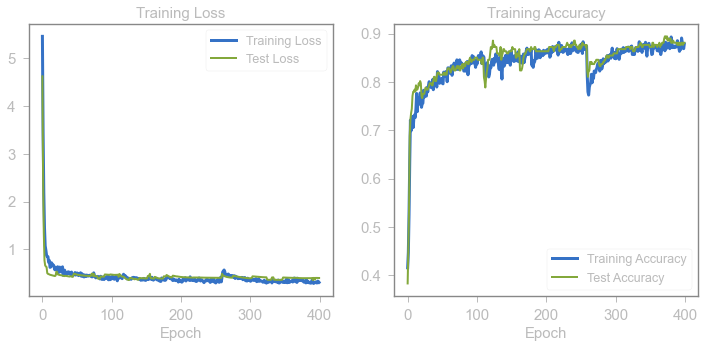

29/29 - 0s - loss: 0.2640 - accuracy: 0.8853
2/2 - 0s - loss: 0.1787 - accuracy: 0.8857
8/8 - 0s - loss: 0.3974 - accuracy: 0.8811
Train loss: 0.2640 Train Acc: 0.8853
Test loss: 0.3974 Test Acc: 0.8811
Validation loss: 0.1787 Validation Acc: 0.8857


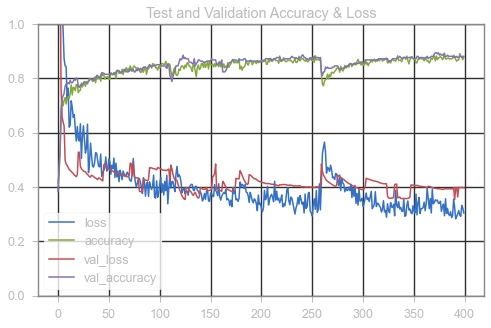

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 19)                456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 692
Trainable params: 692
Non-trainable params: 0
________________________________________________________

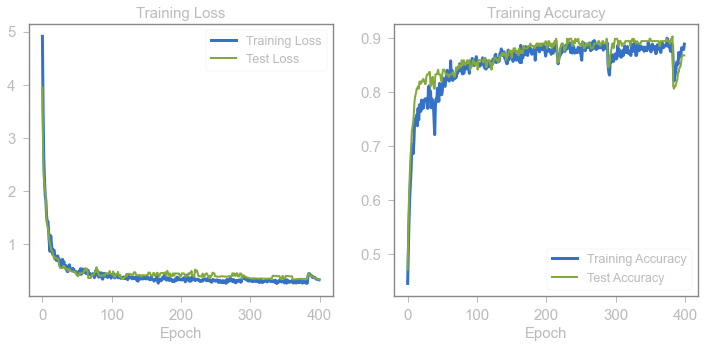

29/29 - 0s - loss: 0.2867 - accuracy: 0.8820
2/2 - 0s - loss: 0.2684 - accuracy: 0.8571
8/8 - 0s - loss: 0.3373 - accuracy: 0.8678
Train loss: 0.2867 Train Acc: 0.8820
Test loss: 0.3373 Test Acc: 0.8678
Validation loss: 0.2684 Validation Acc: 0.8571


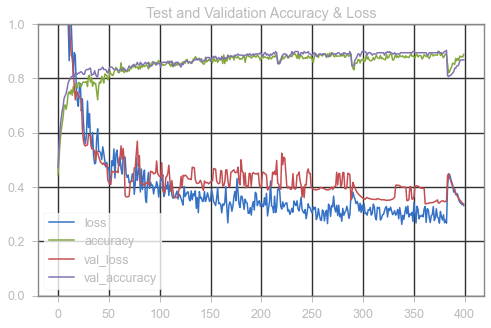

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 98)                10094     
_________________________________________________________________
dropout_4 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 49)                4851      
_________________________________________________________________
dropout_5 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 16,170
Trainable params: 16,170
Non-trainable params: 0
__________________________________________________

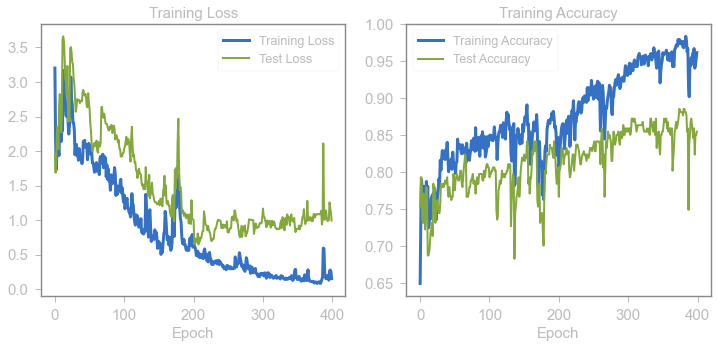

29/29 - 0s - loss: 0.0759 - accuracy: 0.9879
2/2 - 0s - loss: 0.7999 - accuracy: 0.8857
8/8 - 0s - loss: 0.9946 - accuracy: 0.8546
Train loss: 0.0759 Train Acc: 0.9879
Test loss: 0.9946 Test Acc: 0.8546
Validation loss: 0.7999 Validation Acc: 0.8857


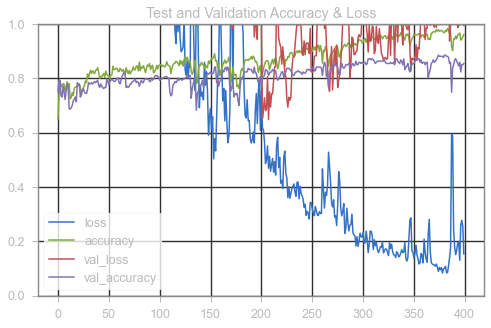

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 102)               10914     
_________________________________________________________________
dropout_6 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 51)                5253      
_________________________________________________________________
dropout_7 (Dropout)          (None, 51)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 26)                1352      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 27        
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
__________________________________________________

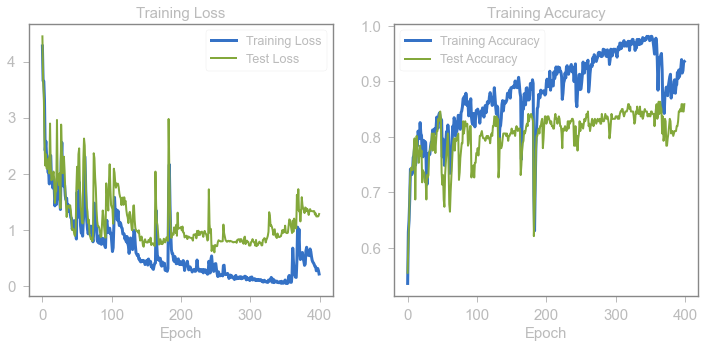

29/29 - 0s - loss: 0.1358 - accuracy: 0.9647
2/2 - 0s - loss: 1.6094 - accuracy: 0.8000
8/8 - 0s - loss: 1.2843 - accuracy: 0.8590
Train loss: 0.1358 Train Acc: 0.9647
Test loss: 1.2843 Test Acc: 0.8590
Validation loss: 1.6094 Validation Acc: 0.8000


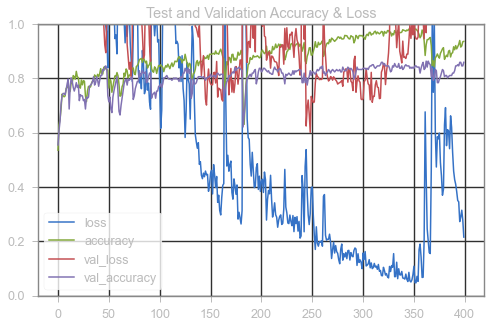

In [43]:
tf_results_train_accuracy = []
tf_results_validation_accuracy = []
tf_results_test_accuracy = []


for n, sample in zip(range(4), samples):
    tf_complete(n, sample)
    
    tf_results_train_accuracy.append(tf_complete.results_tr[1])
    tf_results_validation_accuracy.append(tf_complete.results_va[1])
    tf_results_test_accuracy.append(tf_complete.results_te[1])

# Optuna Tuning

# Notes from Optuna Keras

You can optimize Keras hyperparameters, such as the number of filters and kernel size, in three steps:

* Wrap model training with an objective function and return accuracy
* Suggest hyperparameters using a trial object
* Create a study object and execute the optimization

# These are the things that can be put into the model.

* units	Positive integer, dimensionality of the output space.

* activation	Activation function to use. If you don't specify anything, no activation is applied 
(ie. "linear" activation: a(x) = x).

* use_bias	Boolean, whether the layer uses a bias vector.

* kernel_initializer	Initializer for the kernel weights matrix.

* bias_initializer	Initializer for the bias vector.

* kernel_regularizer	Regularizer function applied to the kernel weights matrix.

* bias_regularizer	Regularizer function applied to the bias vector.

* activity_regularizer	Regularizer function applied to the output of the layer (its "activation").

* kernel_constraint	Constraint function applied to the kernel weights matrix.

* bias_constraint	Constraint function applied to the bias vector.

In [92]:
# optuna_

# 1. Define an objective function to be maximized.

def objective(trial):
    
    length = len(Xtrainscaleds[0][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[0],
        ytrains[0],
        validation_data=(Xtestscaleds[0], ytests[0]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[0], ytests[0], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[0], yvalidations[0], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    
    
    return score[1]




In [93]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

optuna_score = []
print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

    

[I 2021-04-27 18:36:11,869] A new study created in memory with name: no-name-8a1c022a-bb32-447e-a7b8-0dabe41e64f5
[I 2021-04-27 18:36:16,141] Trial 0 finished with value: 0.7136563658714294 and parameters: {'neurons': 12, 'momentum': 0.9256735692385345, 'learning_rate_init': 0.00039431453915803283, 'initializers': 'he_uniform', 'activations': 'softplus', 'weight_constraints': 1, 'epochs': 39, 'batch': 59, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 14}. Best is trial 0 with value: 0.7136563658714294.
[I 2021-04-27 18:36:28,948] Trial 1 finished with value: 0.8678414225578308 and parameters: {'neurons': 20, 'momentum': 0.7606098174022066, 'learning_rate_init': 0.0004164885800408048, 'initializers': 'lecun_uniform', 'activations': 'softplus', 'weight_constraints': 3, 'epochs': 88, 'batch': 28, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 4, 'n_units_l1': 8}. Best is trial 1 with value: 0.8678414225578308.
[I 2021-04-27 18:36:35,693] Trial 2 finished with value: 0.8766520023345

[I 2021-04-27 18:39:15,414] Trial 19 finished with value: 0.43171805143356323 and parameters: {'neurons': 18, 'momentum': 0.5119787812318037, 'learning_rate_init': 1.0095410273223773e-05, 'initializers': 'normal', 'activations': 'hard_sigmoid', 'weight_constraints': 4, 'epochs': 22, 'batch': 24, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 7}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:39:23,631] Trial 20 finished with value: 0.43171805143356323 and parameters: {'neurons': 22, 'momentum': 0.10301451540362795, 'learning_rate_init': 0.0007879771586282907, 'initializers': 'glorot_normal', 'activations': 'sigmoid', 'weight_constraints': 1, 'epochs': 40, 'batch': 16, 'optimizer': 'Nadam', 'n_layers': 2, 'n_units_l0': 5, 'n_units_l1': 13}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:39:38,224] Trial 21 finished with value: 0.8634361028671265 and parameters: {'neurons': 17, 'momentum': 0.5759747748224459, 'learning_rate_init': 0.0001547750407

[I 2021-04-27 18:42:39,104] Trial 39 finished with value: 0.8810572624206543 and parameters: {'neurons': 21, 'momentum': 0.7703780107052919, 'learning_rate_init': 0.00033838960164694546, 'initializers': 'lecun_uniform', 'activations': 'linear', 'weight_constraints': 1, 'epochs': 100, 'batch': 29, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 10}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:42:50,846] Trial 40 finished with value: 0.43171805143356323 and parameters: {'neurons': 12, 'momentum': 0.9344783839646172, 'learning_rate_init': 0.00019532239308062526, 'initializers': 'uniform', 'activations': 'hard_sigmoid', 'weight_constraints': 3, 'epochs': 98, 'batch': 26, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 5}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:42:57,698] Trial 41 finished with value: 0.8810572624206543 and parameters: {'neurons': 16, 'momentum': 0.8074258923527922, 'learning_rate_init': 0.00099431395457679

[I 2021-04-27 18:45:52,877] Trial 59 finished with value: 0.5991189479827881 and parameters: {'neurons': 19, 'momentum': 0.612478885406706, 'learning_rate_init': 4.284247184333854e-05, 'initializers': 'glorot_uniform', 'activations': 'linear', 'weight_constraints': 1, 'epochs': 82, 'batch': 21, 'optimizer': 'Adagrad', 'n_layers': 3, 'n_units_l0': 5, 'n_units_l1': 4, 'n_units_l2': 21}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:46:01,171] Trial 60 finished with value: 0.43171805143356323 and parameters: {'neurons': 18, 'momentum': 0.40533785245533394, 'learning_rate_init': 0.00011317962175951784, 'initializers': 'normal', 'activations': 'hard_sigmoid', 'weight_constraints': 2, 'epochs': 76, 'batch': 44, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 4, 'n_units_l1': 5}. Best is trial 5 with value: 0.9030836820602417.
[I 2021-04-27 18:46:10,805] Trial 61 finished with value: 0.9118942618370056 and parameters: {'neurons': 14, 'momentum': 0.48046681075887143, 'l

Number of finished trials: 63
Best trial:
  Value: 0.9118942618370056
  Params: 
    neurons: 14
    momentum: 0.48046681075887143
    learning_rate_init: 3.644278309122632e-05
    initializers: he_uniform
    activations: linear
    weight_constraints: 4
    epochs: 93
    batch: 38
    optimizer: RMSprop
    n_layers: 2
    n_units_l0: 9
    n_units_l1: 5


In [94]:
optuna_test_scores = []
optuna_val_scores = []

objective.scores

optuna_test_scores.append(objective.scores[0])
optuna_val_scores.append(objective.scores[1])

In [95]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [96]:
def objective(trial):
    
    length = len(Xtrainscaleds[1][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[1],
        ytrains[1],
        validation_data=(Xtestscaleds[1], ytests[1]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[1], ytests[1], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[1], yvalidations[1], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    
    return score[1]




In [97]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-27 18:50:56,745] A new study created in memory with name: no-name-4ce529a1-a778-4d95-99ee-96ffc2012fe1
[I 2021-04-27 18:51:05,040] Trial 0 finished with value: 0.8678414225578308 and parameters: {'neurons': 18, 'momentum': 0.4751483999994782, 'learning_rate_init': 0.00010441398413881366, 'initializers': 'glorot_normal', 'activations': 'softplus', 'weight_constraints': 4, 'epochs': 51, 'batch': 14, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 7, 'n_units_l1': 7}. Best is trial 0 with value: 0.8678414225578308.
[I 2021-04-27 18:51:08,729] Trial 1 finished with value: 0.43171805143356323 and parameters: {'neurons': 18, 'momentum': 0.1284870474827957, 'learning_rate_init': 0.00010522816195067131, 'initializers': 'uniform', 'activations': 'softplus', 'weight_constraints': 5, 'epochs': 28, 'batch': 55, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 4}. Best is trial 0 with value: 0.8678414225578308.
[I 2021-04-27 18:51:12,264] Trial 2 finished with valu

[I 2021-04-27 18:53:20,097] Trial 19 finished with value: 0.8237885236740112 and parameters: {'neurons': 21, 'momentum': 0.11616461465532649, 'learning_rate_init': 5.1946073055268046e-05, 'initializers': 'lecun_uniform', 'activations': 'linear', 'weight_constraints': 4, 'epochs': 78, 'batch': 60, 'optimizer': 'Nadam', 'n_layers': 2, 'n_units_l0': 7, 'n_units_l1': 17}. Best is trial 15 with value: 0.8854625821113586.
[I 2021-04-27 18:53:29,111] Trial 20 finished with value: 0.5682819485664368 and parameters: {'neurons': 17, 'momentum': 0.061560141292660506, 'learning_rate_init': 6.999937484470183e-05, 'initializers': 'normal', 'activations': 'hard_sigmoid', 'weight_constraints': 2, 'epochs': 91, 'batch': 52, 'optimizer': 'Adadelta', 'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 11}. Best is trial 15 with value: 0.8854625821113586.
[I 2021-04-27 18:53:35,430] Trial 21 finished with value: 0.8678414225578308 and parameters: {'neurons': 18, 'momentum': 0.5738803109945338, 'learning_rate_i

[I 2021-04-27 18:56:45,967] Trial 39 finished with value: 0.7621145248413086 and parameters: {'neurons': 15, 'momentum': 0.8482293243846413, 'learning_rate_init': 6.134236436909555e-05, 'initializers': 'glorot_normal', 'activations': 'softmax', 'weight_constraints': 5, 'epochs': 100, 'batch': 58, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 7, 'n_units_l1': 8}. Best is trial 36 with value: 0.8986784219741821.
[I 2021-04-27 18:56:58,289] Trial 40 finished with value: 0.8634361028671265 and parameters: {'neurons': 18, 'momentum': 0.743761422022563, 'learning_rate_init': 8.522842421604079e-05, 'initializers': 'glorot_uniform', 'activations': 'softplus', 'weight_constraints': 5, 'epochs': 81, 'batch': 13, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 12}. Best is trial 36 with value: 0.8986784219741821.
[I 2021-04-27 18:57:09,912] Trial 41 finished with value: 0.43171805143356323 and parameters: {'neurons': 20, 'momentum': 0.9153221841848818, 'learning_rate_init': 

[I 2021-04-27 19:00:48,869] Trial 59 finished with value: 0.8546255230903625 and parameters: {'neurons': 15, 'momentum': 0.8252339913383152, 'learning_rate_init': 1.30015599361468e-05, 'initializers': 'lecun_uniform', 'activations': 'softsign', 'weight_constraints': 1, 'epochs': 80, 'batch': 17, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 6, 'n_units_l1': 10}. Best is trial 36 with value: 0.8986784219741821.
[I 2021-04-27 19:01:00,986] Trial 60 finished with value: 0.8678414225578308 and parameters: {'neurons': 16, 'momentum': 0.472425566068686, 'learning_rate_init': 2.3382151778641156e-05, 'initializers': 'he_uniform', 'activations': 'linear', 'weight_constraints': 1, 'epochs': 98, 'batch': 25, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 5, 'n_units_l1': 13}. Best is trial 36 with value: 0.8986784219741821.


Number of finished trials: 61
Best trial:
  Value: 0.8986784219741821
  Params: 
    neurons: 18
    momentum: 0.8504595851373653
    learning_rate_init: 9.302810670234647e-05
    initializers: glorot_normal
    activations: softsign
    weight_constraints: 5
    epochs: 87
    batch: 20
    optimizer: SGD
    n_layers: 2
    n_units_l0: 7
    n_units_l1: 11


In [98]:
objective.scores

optuna_test_scores.append(objective.scores[0])
optuna_val_scores.append(objective.scores[1])

In [99]:
plot_param_importances(study)

In [100]:
def objective(trial):
    
    length = len(Xtrainscaleds[2][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[2],
        ytrains[2],
        validation_data=(Xtestscaleds[2], ytests[2]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[2], ytests[2], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[2], yvalidations[2], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    return score[1]




In [101]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-27 19:01:03,478] A new study created in memory with name: no-name-6cf1e76a-bd35-457d-81bc-dc162704ace6
[I 2021-04-27 19:01:18,267] Trial 0 finished with value: 0.850220263004303 and parameters: {'neurons': 73, 'momentum': 0.8122277770741402, 'learning_rate_init': 7.876610162766662e-05, 'initializers': 'uniform', 'activations': 'softplus', 'weight_constraints': 4, 'epochs': 95, 'batch': 13, 'optimizer': 'Adamax', 'n_layers': 1, 'n_units_l0': 14}. Best is trial 0 with value: 0.850220263004303.
[I 2021-04-27 19:01:21,707] Trial 1 finished with value: 0.43171805143356323 and parameters: {'neurons': 68, 'momentum': 0.908340601633892, 'learning_rate_init': 0.0009293112636945745, 'initializers': 'glorot_uniform', 'activations': 'softmax', 'weight_constraints': 3, 'epochs': 27, 'batch': 45, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 53, 'n_units_l1': 83}. Best is trial 0 with value: 0.850220263004303.
[I 2021-04-27 19:01:29,047] Trial 2 finished with value: 0.8678414225578308 

[I 2021-04-27 19:03:58,445] Trial 19 finished with value: 0.43171805143356323 and parameters: {'neurons': 102, 'momentum': 0.5764050136391312, 'learning_rate_init': 0.0001619488492057024, 'initializers': 'lecun_uniform', 'activations': 'sigmoid', 'weight_constraints': 3, 'epochs': 100, 'batch': 56, 'optimizer': 'Adamax', 'n_layers': 3, 'n_units_l0': 35, 'n_units_l1': 62, 'n_units_l2': 6}. Best is trial 4 with value: 0.8766520023345947.
[I 2021-04-27 19:04:06,400] Trial 20 finished with value: 0.43171805143356323 and parameters: {'neurons': 47, 'momentum': 0.9904451655323644, 'learning_rate_init': 0.00023466811712148585, 'initializers': 'zero', 'activations': 'softsign', 'weight_constraints': 1, 'epochs': 54, 'batch': 26, 'optimizer': 'Nadam', 'n_layers': 2, 'n_units_l0': 99, 'n_units_l1': 10}. Best is trial 4 with value: 0.8766520023345947.
[I 2021-04-27 19:04:13,530] Trial 21 finished with value: 0.8237885236740112 and parameters: {'neurons': 35, 'momentum': 0.7587431667438354, 'learn

[I 2021-04-27 19:06:06,741] Trial 38 finished with value: 0.8722466826438904 and parameters: {'neurons': 53, 'momentum': 0.41831900477256573, 'learning_rate_init': 0.00013994810331969526, 'initializers': 'he_uniform', 'activations': 'linear', 'weight_constraints': 5, 'epochs': 72, 'batch': 41, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 29, 'n_units_l1': 5, 'n_units_l2': 15}. Best is trial 4 with value: 0.8766520023345947.
[I 2021-04-27 19:06:14,827] Trial 39 finished with value: 0.8370044231414795 and parameters: {'neurons': 52, 'momentum': 0.3334193925679291, 'learning_rate_init': 0.0001332060075841178, 'initializers': 'glorot_uniform', 'activations': 'relu', 'weight_constraints': 4, 'epochs': 72, 'batch': 48, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 27, 'n_units_l1': 28, 'n_units_l2': 5}. Best is trial 4 with value: 0.8766520023345947.
[I 2021-04-27 19:06:24,934] Trial 40 finished with value: 0.8590308427810669 and parameters: {'neurons': 75, 'momentum': 0.42503

[I 2021-04-27 19:08:48,432] Trial 57 finished with value: 0.6607929468154907 and parameters: {'neurons': 49, 'momentum': 0.5968251364519495, 'learning_rate_init': 1.3049322410872461e-05, 'initializers': 'glorot_normal', 'activations': 'linear', 'weight_constraints': 3, 'epochs': 64, 'batch': 39, 'optimizer': 'Nadam', 'n_layers': 3, 'n_units_l0': 37, 'n_units_l1': 50, 'n_units_l2': 21}. Best is trial 41 with value: 0.8986784219741821.
[I 2021-04-27 19:08:59,974] Trial 58 finished with value: 0.43171805143356323 and parameters: {'neurons': 94, 'momentum': 0.048407048624541926, 'learning_rate_init': 0.00042457204650378727, 'initializers': 'he_uniform', 'activations': 'hard_sigmoid', 'weight_constraints': 4, 'epochs': 96, 'batch': 38, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 42, 'n_units_l1': 5, 'n_units_l2': 12}. Best is trial 41 with value: 0.8986784219741821.
[I 2021-04-27 19:09:08,967] Trial 59 finished with value: 0.8854625821113586 and parameters: {'neurons': 44, 'momentu

Number of finished trials: 73
Best trial:
  Value: 0.8986784219741821
  Params: 
    neurons: 60
    momentum: 0.5058612847539106
    learning_rate_init: 0.00041030715283864544
    initializers: he_uniform
    activations: linear
    weight_constraints: 5
    epochs: 64
    batch: 41
    optimizer: RMSprop
    n_layers: 3
    n_units_l0: 38
    n_units_l1: 4
    n_units_l2: 14


In [102]:
objective.scores

optuna_test_scores.append(objective.scores[0])
optuna_val_scores.append(objective.scores[1])

In [103]:
plot_param_importances(study)

In [104]:
def objective(trial):
    
    length = len(Xtrainscaleds[3][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[3],
        ytrains[3],
        validation_data=(Xtestscaleds[3], ytests[3]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[3], ytests[3], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[3], yvalidations[3], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    return score[1]




In [105]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-27 19:11:09,822] A new study created in memory with name: no-name-d1073123-875f-4fe8-8219-3d50af3e4f31
[I 2021-04-27 19:11:19,975] Trial 0 finished with value: 0.7929515242576599 and parameters: {'neurons': 51, 'momentum': 0.36922763125480773, 'learning_rate_init': 1.730232602202315e-05, 'initializers': 'he_uniform', 'activations': 'softmax', 'weight_constraints': 4, 'epochs': 83, 'batch': 30, 'optimizer': 'Adamax', 'n_layers': 2, 'n_units_l0': 17, 'n_units_l1': 14}. Best is trial 0 with value: 0.7929515242576599.
[I 2021-04-27 19:11:27,103] Trial 1 finished with value: 0.43171805143356323 and parameters: {'neurons': 68, 'momentum': 0.887921367246574, 'learning_rate_init': 0.00022956109757613018, 'initializers': 'lecun_uniform', 'activations': 'softmax', 'weight_constraints': 2, 'epochs': 40, 'batch': 17, 'optimizer': 'Adamax', 'n_layers': 3, 'n_units_l0': 66, 'n_units_l1': 34, 'n_units_l2': 56}. Best is trial 0 with value: 0.7929515242576599.
[I 2021-04-27 19:11:35,396] Tri

[I 2021-04-27 19:13:38,373] Trial 19 finished with value: 0.8325991034507751 and parameters: {'neurons': 104, 'momentum': 0.4668687238675886, 'learning_rate_init': 0.00036758065173924135, 'initializers': 'he_normal', 'activations': 'softsign', 'weight_constraints': 2, 'epochs': 32, 'batch': 25, 'optimizer': 'Adam', 'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 23, 'n_units_l2': 15}. Best is trial 16 with value: 0.8722466826438904.
[I 2021-04-27 19:13:45,754] Trial 20 finished with value: 0.850220263004303 and parameters: {'neurons': 86, 'momentum': 0.2005465171141082, 'learning_rate_init': 0.00018404016305537354, 'initializers': 'glorot_uniform', 'activations': 'tanh', 'weight_constraints': 1, 'epochs': 49, 'batch': 42, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 33, 'n_units_l1': 65}. Best is trial 16 with value: 0.8722466826438904.
[I 2021-04-27 19:13:51,744] Trial 21 finished with value: 0.850220263004303 and parameters: {'neurons': 91, 'momentum': 0.2165745472862478, 'lea

[I 2021-04-27 19:15:34,455] Trial 39 finished with value: 0.8722466826438904 and parameters: {'neurons': 105, 'momentum': 0.6325094191394897, 'learning_rate_init': 0.000777106155062524, 'initializers': 'normal', 'activations': 'hard_sigmoid', 'weight_constraints': 3, 'epochs': 27, 'batch': 14, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 14}. Best is trial 38 with value: 0.8942731022834778.
[I 2021-04-27 19:21:23,006] Trial 40 finished with value: 0.8810572624206543 and parameters: {'neurons': 106, 'momentum': 0.7963434464504496, 'learning_rate_init': 0.0006050961713200505, 'initializers': 'normal', 'activations': 'hard_sigmoid', 'weight_constraints': 3, 'epochs': 38, 'batch': 15, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 18}. Best is trial 38 with value: 0.8942731022834778.


Number of finished trials: 41
Best trial:
  Value: 0.8942731022834778
  Params: 
    neurons: 106
    momentum: 0.6362506644100496
    learning_rate_init: 0.0005222906375454856
    initializers: normal
    activations: hard_sigmoid
    weight_constraints: 3
    epochs: 41
    batch: 15
    optimizer: RMSprop
    n_layers: 1
    n_units_l0: 14


In [106]:
objective.scores

optuna_test_scores.append(objective.scores[0])
optuna_val_scores.append(objective.scores[1])

In [107]:
plot_param_importances(study)

In [108]:
# from optuna.visualization import plot_contour


# plot_contour(study)

In [109]:
# optuna.visualization.plot_contour

from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [110]:
# from optuna.visualization import plot_intermediate_values

# plot_intermediate_values(study)

from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [111]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

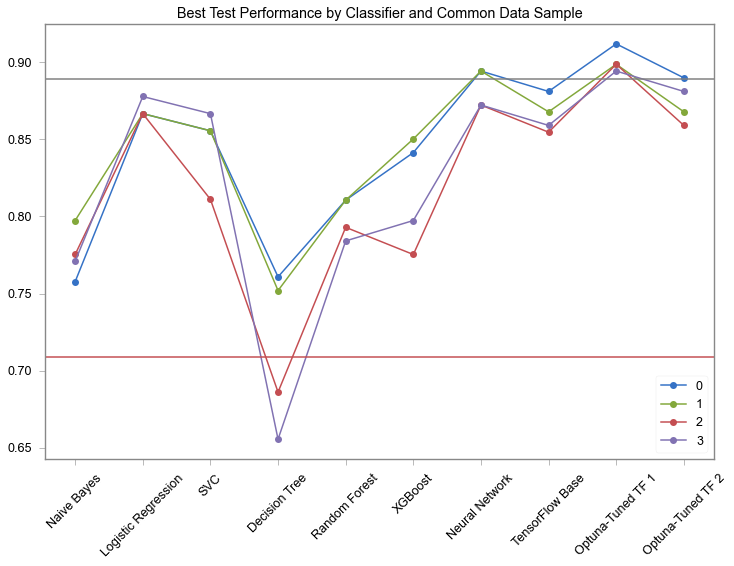

In [117]:
test_results_2 = pd.DataFrame([nb_test_accuracies, lr_test_accuracies, svc_test_accuracies, dt_test_accuracies,
                            rf_test_accuracies, XGB_test_accuracies, nn_test_accuracies, tf_results_test_accuracy,
                            optuna_score, optuna_test_scores])

test_results_2['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                             'Neural Network', 'TensorFlow Base', 'Optuna-Tuned TF 1', 'Optuna-Tuned TF 2']

test_results_2.set_index('Classifier', inplace = True)

plt.figure(figsize=(12,8))
plt.plot(test_results_2, marker = 'o')
plt.xticks(rotation = 45, color = 'black')
plt.yticks(color = 'black')
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
legend = plt.legend((test_results_2.columns), loc = 'lower right')
plt.setp(legend.get_texts(), color='black')
plt.title('Best Test Performance by Classifier and Common Data Sample', color = 'black');

In [113]:
test_results_2

0         1         2         3
Classifier                                                 
Naive Bayes          0.757709  0.797357  0.775330  0.770925
Logistic Regression  0.866667  0.866667  0.866667  0.877778
SVC                  0.855556  0.855556  0.811111  0.866667
Decision Tree        0.760833  0.751944  0.686111  0.655556
Random Forest        0.810573  0.810573  0.792952  0.784141
XGBoost              0.841410  0.850220  0.775330  0.797357
Neural Network       0.894273  0.894273  0.872247  0.872247
TensorFlow Base      0.881057  0.867841  0.854626  0.859031
Optuna-Tuned TF      0.889868  0.867841  0.859031  0.881057

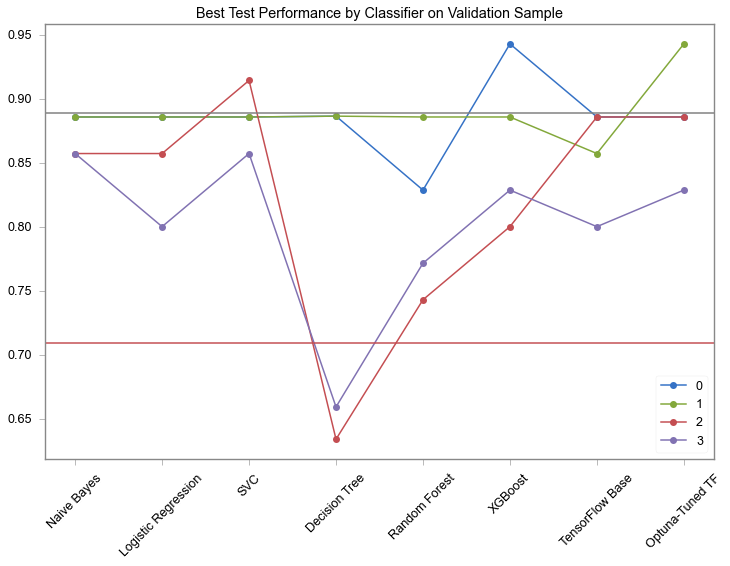

In [114]:
val_results = pd.DataFrame([nb_validation_accuracies, lr_validation_accuracies, svc_validation_accuracies, 
                            dt_val_accuracies, rf_val_accuracies, XGB_val_accuracies, tf_results_validation_accuracy,
                           optuna_val_scores])
                           
#                            , nn_test_accuracies, tf_results_test_accuracy,
#                             optuna_score])

val_results['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                            'TensorFlow Base', 'Optuna-Tuned TF']
#                              'Neural Network', 'TensorFlow Base', 'Optuna-Tuned TF']

val_results.set_index('Classifier', inplace = True)

plt.figure(figsize=(12,8))
plt.plot(val_results, marker = 'o')
plt.xticks(rotation = 45, color = 'black')
plt.yticks(color = 'black')
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
legend = plt.legend((val_results.columns), loc = 'lower right')
plt.setp(legend.get_texts(), color='black')
plt.title('Best Test Performance by Classifier on Validation Sample', color = 'black');

In [115]:
val_results

0         1         2         3
Classifier                                                 
Naive Bayes          0.885714  0.885714  0.857143  0.857143
Logistic Regression  0.885714  0.885714  0.857143  0.800000
SVC                  0.885714  0.885714  0.914286  0.857143
Decision Tree        0.886364  0.886364  0.633838  0.659091
Random Forest        0.828571  0.885714  0.742857  0.771429
XGBoost              0.942857  0.885714  0.800000  0.828571
TensorFlow Base      0.885714  0.857143  0.885714  0.800000
Optuna-Tuned TF      0.885714  0.942857  0.885714  0.828571

In [64]:
# Is any of this significant?

# from mlxtend.evaluate import paired_ttest_5x2cv
# # check if difference between algorithms is real
# t, p = paired_ttest_5x2cv(estimator1=model1, 
#                           estimator2=model2, 
#                           X=X, 
#                           y=y, 
#                           scoring='accuracy', 
#                           random_seed=1)
# # summarize
# print(f'The P-value is = {p:.3f}')
# print(f'The t-statistics is = {t:.3f}')
# # interpret the result
# if p <= 0.05:
#     print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
# else:
#     print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

# Forecasting Playground

First, let's just get the 2021 data as it comes in and run predict on it.

In [65]:
# First, let's take a look at non-normalized data and look at RLP on the X axis and Point Differential on the Y.
# Let's have circles be home win and squares be away wins and then let's let year be represented by color.

In [66]:
baseline_hanc.head()

Home         Away  Season   Game    Round   D-DI   D-KI  D-MK  D-HB  \
0         GWS       Sydney    2012  Game1  round01  -31.0  -28.0 -18.0  -3.0   
1    Richmond      Carlton    2012  Game2  round01  -44.0  -37.0 -20.0  -7.0   
2    Hawthorn  Collingwood    2012  Game3  round01   38.0   15.0  12.0  23.0   
3   Melbourne     Brisbane    2012  Game4  round01  -36.0  -13.0 -25.0 -23.0   
4  Gold Coast     Adelaide    2012  Game5  round01 -225.0 -132.0 -70.0 -93.0   

   D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  Intrastate  \
0   0.0  ...     -4.0     0.208333    -1.666667 -1.916667           0   
1   0.0  ...    -11.0     1.833333     1.333333 -2.500000           0   
2   2.0  ...     17.0    -1.000000    -7.583333  2.708333           0   
3   0.0  ...     17.0     5.000000     2.472222 -1.583333           1   
4  -1.0  ...    -34.0     7.517857     3.089286 -1.535714           1   

   Same / Neutral Venue  Clash  RLP  Net Score  Winner  
0                     1      1   11        -63    Away  
1                     0      0    7        -44    Away  
2                     1      1    2         22    Home  
3                     0      0   -2        -41    Away  
4                     0      0    3        -69    Away  

[5 rows x 113 columns]

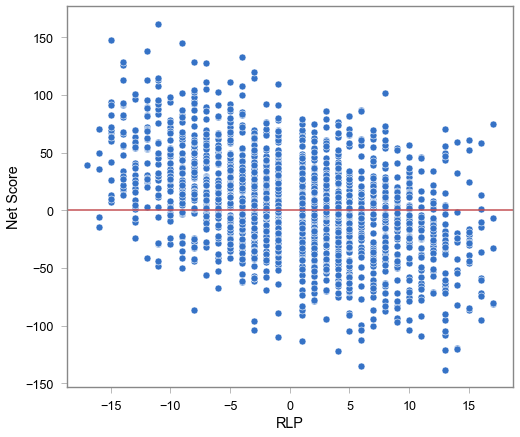

In [67]:
ax = sns.scatterplot(data = baseline_hanc, x = 'RLP', y = 'Net Score')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
plt.axhline(y=0, color='r', linestyle='-');


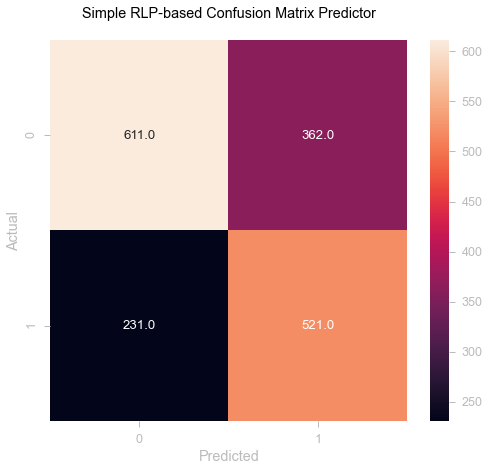

In [68]:
confusion = copy.deepcopy(baseline_hanc)
confusion = confusion[['RLP', 'Net Score']]
confusion['TF'] = np.where(((confusion['RLP'] <0) & (confusion['Net Score'] > 0)) | (confusion['RLP'] > 0) & (confusion['Net Score'] < 0), 'True', 'False')
confusion['y_pred'] = np.where((confusion['RLP'] < 0), 0, 1)
confusion['y_actual'] = np.where((confusion['Net Score'] > 0), 0, 1)

simple = confusion.groupby('TF').count()

pct_against = (simple.loc['False']['RLP'] / (simple.loc['False']['RLP'] + simple.loc['True']['RLP'])) * 100
pct_with = (simple.loc['True']['RLP'] / (simple.loc['False']['RLP'] + simple.loc['True']['RLP'])) * 100

confusion_matrix = pd.crosstab(confusion['y_actual'], confusion['y_pred'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt=".1f")
plt.title('Simple RLP-based Confusion Matrix Predictor\n', color = 'black')
plt.show()

In [69]:
pct_against, pct_with

(34.3768115942029, 65.62318840579711)

So, this says that, if I just look at the RLP and pick WITH RLP, historically, I'll pick the winner 65% of the time.  RLP is an adequate predictor of outcome, even if no other information is known.

# Data Forecasting in Python

In [70]:
# Here is the BetFair Detour.  Some of this is useful - it establishes rolling averages, which I like.
# I had actually done that before, but didn't quite know how to operationalize it.

In [71]:
def home_away_simple(home_fixture, away_fixture, master_df):
    '''
    This takes a df of the fixtures, broken out by home and away and then combines them, using
    the data from the master_df that was created with all of the PI for each season
    
    '''
    import pandas as pd

    home_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
    away_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)

    home_fixture['Game'] = home_fixture['Game'].str.lstrip(string.digits)
    away_fixture['Game'] = away_fixture['Game'].str.lstrip(string.digits)

    home_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)
    away_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)

    home_list = pd.merge(home_fixture, master_df, how = 'left', left_on = ['Year', 'Home', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])
    away_list = pd.merge(away_fixture, master_df, how = 'left', left_on = ['Year', 'Away', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])

    away_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    home_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    
    return [home_list, away_list]

In [72]:
homeaway_list = home_away_simple(home, away, baseline_df)

In [73]:
homeaway_list[0]

Year    Round   Game         Home  Home Score             Venue  \
0     2012  round01  Game1          GWS          37       ANZ Stadium   
1     2012  round01  Game2     Richmond          81               MCG   
2     2012  round01  Game3     Hawthorn         137               MCG   
3     2012  round01  Game4    Melbourne          78               MCG   
4     2012  round01  Game5   Gold Coast          68          Metricon   
...    ...      ...    ...          ...         ...               ...   
1731  2020  round18  Game5     Brisbane          78             Gabba   
1732  2020  round18  Game6     Hawthorn         108     Adelaide Oval   
1733  2020  round18  Game7       Sydney          63          Metricon   
1734  2020  round18  Game8    Fremantle          44  Cazaly's Stadium   
1735  2020  round18  Game9  Collingwood          45             Gabba   

           Home Field-H Home State  LP-H   D-DI  ...  R-UP  R-CM  R-MI  R-1%  \
0     Sydney Showground        NSW    18  112.0  ...   7.0   1.0   1.0   3.0   
1                   MCG        VIC    12   84.0  ...   8.0   1.0   0.0   2.0   
2                   MCG        VIC     3  141.0  ...  14.0   2.0   2.0   8.0   
3                   MCG        VIC    13  126.0  ...   5.0   5.0   1.0   5.0   
4              Metricon        QLD    17  107.0  ...  14.0   0.0   1.0  12.0   
...                 ...        ...   ...    ...  ...   ...   ...   ...   ...   
1731              Gabba        QLD     2   72.0  ...   2.0   1.0   0.0   0.0   
1732                MCG        VIC    16  142.0  ...  10.0   3.0   0.0   2.0   
1733                SCG        NSW    15  109.0  ...   9.0   0.0   0.0   2.0   
1734      Perth Stadium         WA    11  125.0  ...  10.0   4.0   1.0   3.0   
1735                MCG        VIC     6  121.0  ...  23.0   0.0   0.0  10.0   

      R-BO   R-AMG  R-GA  R-Height  R-Weight  R-Age  
0      0.0    0.00   0.0     200.0     103.0   24.0  
1      0.0    0.00   1.0     200.0     102.0   26.0  
2      0.0    0.00   1.0     201.5     100.0   27.0  
3      0.0    0.00   1.0     198.0     102.0   27.5  
4      0.0    0.00   1.0     202.0      96.0   21.0  
...    ...     ...   ...       ...       ...    ...  
1731   0.0   81.88   1.0     198.0     103.0   34.0  
1732   0.0  148.58   0.0     187.5      84.5   32.0  
1733   0.0  132.38   0.0     200.0      95.0   31.0  
1734   0.0  281.91   2.0     203.5     104.0   24.5  
1735   0.0  211.38   0.0     201.0     100.5   28.0  

[1736 rows x 109 columns]

In [74]:
# master_seasonPI_df.head()

pred_home = homeaway_list[0]
pred_away = homeaway_list[1]

pred_home.drop(columns = ['Venue', 'Home Field-H', 'Home State'], inplace = True)
pred_away.drop(columns = ['Home Field-A', 'Away State'], inplace = True)
pred_home.insert(4, 'H/A', 'H')
pred_away.insert(4, 'H/A', 'A')

pred_home = pred_home.reset_index()
pred_away = pred_away.reset_index()

pred_home.rename(columns = {'Home Score': 'Score', 'LP-H': 'LP', 'Home': 'Team', 'index': 'Game_ID'}, inplace = True)
pred_away.rename(columns = {'Away Score': 'Score', 'LP-A': 'LP', 'Away': 'Team', 'index': 'Game_ID'}, inplace = True)

pred_ha_tuple = (pred_home, pred_away)
pred_ha_concat = pd.concat(pred_ha_tuple, ignore_index = True)

In [75]:
pred_away[pred_away['Year'] >= 2015]

Game_ID  Year    Round   Game              Team H/A  Score  LP   D-DI  \
594       594  2015  round01  Game1          Richmond   A    105   8  162.0   
595       595  2015  round01  Game2        Gold Coast   A     89  12  132.0   
596       596  2015  round01  Game3          Essendon   A     60   7  125.0   
597       597  2015  round01  Game4       Collingwood   A     86  11  124.0   
598       598  2015  round01  Game5        West Coast   A     87   9  103.0   
...       ...   ...      ...    ...               ...  ..    ...  ..    ...   
1731     1731  2020  round18  Game5           Carlton   A     61  12   93.0   
1732     1732  2020  round18  Game6        Gold Coast   A     57  14   74.0   
1733     1733  2020  round18  Game7           Geelong   A     69   4  160.0   
1734     1734  2020  round18  Game8  Western Bulldogs   A     74   8  104.0   
1735     1735  2020  round18  Game9     Port Adelaide   A     61   1  131.0   

       D-KI  ...  R-UP  R-CM  R-MI  R-1%  R-BO   R-AMG  R-GA  R-Height  \
594    93.0  ...   4.0   2.0   0.0   1.0   0.0  141.59   0.0    200.00   
595    85.0  ...  11.0   1.0   3.0   1.0   0.0   95.55   1.0    202.50   
596    83.0  ...   5.0   0.0   0.0   4.0   0.0  118.40   0.0    202.00   
597    64.0  ...   5.0   0.0   0.0   0.0   0.0  178.00   0.0    202.00   
598    65.0  ...   7.0   1.0   1.0   6.0   3.0  158.67   1.0    202.00   
...     ...  ...   ...   ...   ...   ...   ...     ...   ...       ...   
1731   71.0  ...   4.0   1.0   0.0   6.0   0.0  209.77   0.0    201.00   
1732   46.0  ...   1.0   0.0   0.0   2.0   0.0  125.12   0.0    208.00   
1733  106.0  ...   0.0   0.0   0.0   0.0   0.0    0.00   0.0    188.45   
1734   70.0  ...  18.0   2.0   2.0   7.0   1.0  392.61   1.0    201.50   
1735   93.0  ...   5.0   0.0   0.0   1.0   1.0  131.73   0.0    203.00   

      R-Weight  R-Age  
594     102.00   29.0  
595      97.00   24.0  
596     110.00   26.0  
597     101.00   21.0  
598     103.50   24.0  
...        ...    ...  
1731     95.50   22.5  
1732    113.00   28.0  
1733     88.05   27.1  
1734     91.00   21.5  
1735     98.00   28.0  

[1142 rows x 108 columns]

In [76]:
# Let's see what happens if I try to create this exponential moving average (EMA)

def create_exp_weighted_avgs(df, span):
    
    ema_features = df[['Game_ID', 'Team']].copy()
        
    feature_names = df.iloc[:, 6:].columns
    
    for feature_name in feature_names:
        feature_ema = (df.groupby(['Team'])[feature_name].transform(lambda row: (row.ewm(span = span).mean().shift(1))))
        
        ema_features[feature_name] = feature_ema
        
    return ema_features
    

In [77]:
# Yes, this is the problem.  This function has no idea that there are two data frames here, so it treats the A like a
# continuation of H.  This is an easy fix though!

# In the end it all washes out, but now it should match up.

home_rolling_averages = create_exp_weighted_avgs(pred_home, span=10)
away_rolling_averages = create_exp_weighted_avgs(pred_away, span=10)
home_rolling_averages

Game_ID         Team      Score         LP        D-DI       D-KI  \
0           0          GWS        NaN        NaN         NaN        NaN   
1           1     Richmond        NaN        NaN         NaN        NaN   
2           2     Hawthorn        NaN        NaN         NaN        NaN   
3           3    Melbourne        NaN        NaN         NaN        NaN   
4           4   Gold Coast        NaN        NaN         NaN        NaN   
...       ...          ...        ...        ...         ...        ...   
1731     1731     Brisbane  77.489234   3.910289   92.191108  64.663190   
1732     1732     Hawthorn  63.655293  12.861394   89.263022  55.683433   
1733     1733       Sydney  63.963636  14.209203  110.750554  68.662474   
1734     1734    Fremantle  50.699857  13.741549  115.211282  72.807722   
1735     1735  Collingwood  66.088659   6.639081  105.606533  65.704341   

           D-MK       D-HB      D-GL      D-BH  ...       R-UP      R-CM  \
0           NaN        NaN       NaN       NaN  ...        NaN       NaN   
1           NaN        NaN       NaN       NaN  ...        NaN       NaN   
2           NaN        NaN       NaN       NaN  ...        NaN       NaN   
3           NaN        NaN       NaN       NaN  ...        NaN       NaN   
4           NaN        NaN       NaN       NaN  ...        NaN       NaN   
...         ...        ...       ...       ...  ...        ...       ...   
1731  30.336383  27.256285  0.160753  0.213114  ...   2.616894  0.220191   
1732  27.248306  32.619210  0.104422  0.134192  ...   9.413669  3.417824   
1733  25.797962  42.595286  0.603659  0.174769  ...   4.182149  0.518520   
1734  26.118212  42.271534  0.230126  0.051023  ...   8.006743  2.844363   
1735  25.370916  40.065259  0.886500  1.048445  ...  19.067463  1.682396   

          R-MI      R-1%          R-BO       R-AMG      R-GA    R-Height  \
0          NaN       NaN           NaN         NaN       NaN         NaN   
1          NaN       NaN           NaN         NaN       NaN         NaN   
2          NaN       NaN           NaN         NaN       NaN         NaN   
3          NaN       NaN           NaN         NaN       NaN         NaN   
4          NaN       NaN           NaN         NaN       NaN         NaN   
...        ...       ...           ...         ...       ...         ...   
1731  0.110919  1.602045  0.000000e+00   54.569730  0.318180  195.897956   
1732  0.490897  7.825042  6.535740e-06  158.090814  0.508204  185.329280   
1733  0.212172  2.674080  0.000000e+00   96.361638  0.136439  198.037699   
1734  1.640002  5.060565  1.494668e-07  265.031553  0.380694  203.870639   
1735  0.099159  9.209166  3.672293e-01  258.422977  0.152851  201.289521   

        R-Weight      R-Age  
0            NaN        NaN  
1            NaN        NaN  
2            NaN        NaN  
3            NaN        NaN  
4            NaN        NaN  
...          ...        ...  
1731   95.875925  27.417470  
1732   83.987431  31.782221  
1733   92.265534  28.193006  
1734  104.629812  24.971773  
1735  100.550920  27.400614  

[1736 rows x 104 columns]

In [78]:
home_rolling_averages[home_rolling_averages['Game_ID'] >= 594]

Game_ID              Team      Score         LP        D-DI        D-KI  \
594       594           Carlton  93.629030  12.885726  129.796643   86.389234   
595       595         Melbourne  47.901684  15.771617  126.391053   80.841724   
596       596            Sydney  98.426081   3.159459  171.939618  102.408325   
597       597          Brisbane  73.313929  16.002123  168.347358   87.409681   
598       598  Western Bulldogs  88.701588  13.807420   99.417064   55.745369   
...       ...               ...        ...        ...         ...         ...   
1731     1731          Brisbane  77.489234   3.910289   92.191108   64.663190   
1732     1732          Hawthorn  63.655293  12.861394   89.263022   55.683433   
1733     1733            Sydney  63.963636  14.209203  110.750554   68.662474   
1734     1734         Fremantle  50.699857  13.741549  115.211282   72.807722   
1735     1735       Collingwood  66.088659   6.639081  105.606533   65.704341   

           D-MK       D-HB      D-GL      D-BH  ...       R-UP      R-CM  \
594   44.880758  43.407409  3.661450  2.283835  ...   4.301192  0.757047   
595   38.220746  45.549329  1.920161  2.781989  ...  12.268746  2.520054   
596   38.809564  69.531293  2.286670  1.826424  ...   7.794431  1.581973   
597   45.393197  80.937676  3.056654  2.700416  ...  11.087515  0.539529   
598   24.759229  43.671695  1.031890  1.192075  ...  10.565108  1.495106   
...         ...        ...       ...       ...  ...        ...       ...   
1731  30.336383  27.256285  0.160753  0.213114  ...   2.616894  0.220191   
1732  27.248306  32.619210  0.104422  0.134192  ...   9.413669  3.417824   
1733  25.797962  42.595286  0.603659  0.174769  ...   4.182149  0.518520   
1734  26.118212  42.271534  0.230126  0.051023  ...   8.006743  2.844363   
1735  25.370916  40.065259  0.886500  1.048445  ...  19.067463  1.682396   

          R-MI      R-1%          R-BO       R-AMG      R-GA    R-Height  \
594   0.389194  3.560629  0.000000e+00    0.000000  0.031726  204.435219   
595   1.033556  4.701438  1.303340e-01    0.000000  0.637849  198.561294   
596   1.956196  4.114974  0.000000e+00    0.000000  0.387742  201.574193   
597   0.039929  2.603484  0.000000e+00    0.000000  0.322762  198.711061   
598   0.327226  8.793034  1.665053e-01    0.000000  0.544599  199.342103   
...        ...       ...           ...         ...       ...         ...   
1731  0.110919  1.602045  0.000000e+00   54.569730  0.318180  195.897956   
1732  0.490897  7.825042  6.535740e-06  158.090814  0.508204  185.329280   
1733  0.212172  2.674080  0.000000e+00   96.361638  0.136439  198.037699   
1734  1.640002  5.060565  1.494668e-07  265.031553  0.380694  203.870639   
1735  0.099159  9.209166  3.672293e-01  258.422977  0.152851  201.289521   

        R-Weight      R-Age  
594   104.481550  26.731656  
595   101.262700  27.432562  
596   103.349193  27.571887  
597   103.088243  27.491349  
598   103.985101  26.069551  
...          ...        ...  
1731   95.875925  27.417470  
1732   83.987431  31.782221  
1733   92.265534  28.193006  
1734  104.629812  24.971773  
1735  100.550920  27.400614  

[1142 rows x 104 columns]

In [79]:
away_rolling_averages[away_rolling_averages['Game_ID'] >= 594]

Game_ID              Team       Score         LP        D-DI       D-KI  \
594       594          Richmond   85.592097  11.539083  135.937797  76.307790   
595       595        Gold Coast   76.706992   9.212010   89.312973  54.974143   
596       596          Essendon   78.800686   7.503721  108.368330  65.507046   
597       597       Collingwood   76.187745   7.451870  107.113614  63.178502   
598       598        West Coast  101.960797   9.628466  107.070870  68.123871   
...       ...               ...         ...        ...         ...        ...   
1731     1731           Carlton   54.717504  13.584822   93.804174  69.441679   
1732     1732        Gold Coast   52.848572  12.384840   94.207119  61.888176   
1733     1733           Geelong   71.124782   3.472197  151.736229  99.066368   
1734     1734  Western Bulldogs   71.096430  10.171271  118.599198  73.945671   
1735     1735     Port Adelaide   68.894929   3.230232  120.168772  82.147761   

           D-MK       D-HB      D-GL      D-BH  ...       R-UP      R-CM  \
594   30.607065  59.630007  1.293041  1.282276  ...   6.542290  0.623064   
595   23.084013  34.338830  0.811906  0.763227  ...   3.938684  0.119801   
596   33.631377  42.861284  3.521992  2.133282  ...   8.627856  0.753765   
597   28.579955  43.935112  1.328700  1.072493  ...   7.420376  0.918027   
598   34.162005  38.946999  2.162875  0.953457  ...  13.934669  1.639583   
...         ...        ...       ...       ...  ...        ...       ...   
1731  30.124562  24.197421  0.349089  0.757044  ...   3.595600  1.516065   
1732  27.510414  32.403712  1.036097  0.498171  ...   5.371902  0.425110   
1733  48.200725  52.729532  0.987862  0.628750  ...   4.128768  0.517635   
1734  32.101876  45.571757  2.685498  2.661161  ...  19.244702  1.479594   
1735  32.942262  36.939438  0.485693  1.122588  ...   8.570005  0.941623   

          R-MI      R-1%      R-BO       R-AMG      R-GA    R-Height  \
594   0.419449  4.093135  0.099716    0.000000  0.544954  200.194315   
595   0.208188  1.703220  0.027151    0.000000  0.274348  200.503449   
596   1.153190  4.160743  0.000000    0.000000  0.755576  197.882548   
597   0.705357  3.276650  0.106060    0.000000  0.556877  205.762191   
598   1.432470  6.211614  0.398831    0.000000  0.584017  202.038407   
...        ...       ...       ...         ...       ...         ...   
1731  0.222902  3.416568  0.000009  141.408709  0.061521  201.024888   
1732  0.120007  3.860483  0.021906  143.842251  0.033360  207.982499   
1733  0.448834  2.825932  0.020273  107.524675  0.190798  196.174874   
1734  0.515809  6.217091  0.236305  331.110257  0.095207  201.160668   
1735  0.901379  6.349681  0.020040  217.969190  0.497487  200.772538   

        R-Weight      R-Age  
594   102.502335  27.724625  
595    95.021680  22.860773  
596    97.433071  25.631763  
597   109.140779  21.993163  
598   104.433559  25.314959  
...          ...        ...  
1731   98.680474  24.739812  
1732  112.968202  27.667604  
1733   93.398150  28.528843  
1734   90.412308  21.735689  
1735   96.776846  30.624944  

[1142 rows x 104 columns]

# Form between teams

This is scoring aware.  I don't think I want to do this.

In [80]:
fbt_home = homeaway_list[0]
fbt_away = homeaway_list[1]

In [81]:
match_results_home = fbt_home[['Home', 'Home Score']]
match_results_away = fbt_away[['Away', 'Away Score']]

# df = pd.merge(df2, df1, how='left')

match_results1 = pd.merge(match_results_home, match_results_away, how = 'left', left_index = True, right_index = True)
match_results2 = pd.merge(match_results_away, match_results_home, how = 'left', left_index = True, right_index = True)

match_results1['Margin'] = match_results1['Home Score'] - match_results1['Away Score']
match_results2['Margin'] = match_results2['Away Score'] - match_results2['Home Score']

match_results1.rename(columns = {'Home': 'Team', 'Away': 'Opponent'}, inplace = True)
# mra = match_results1[['Team', 'Opponent', 'Margin']]

match_results2.rename(columns = {'Away': 'Team', 'Home': 'Opponent'}, inplace = True)
# mrb = match_results2[['Team', 'Opponent', 'Margin']]

mr_concat_tuple = (match_results1, match_results2)
mr_concat = pd.concat(mr_concat_tuple, ignore_index = True)

In [82]:
form_btwn_teams = mr_concat.copy()

form_btwn_teams['form_margin_between_teams'] = (mr_concat.groupby(['Team', 'Opponent'])['Margin']\
                                                .transform(lambda row: row.rolling(5).mean().shift().fillna(0)))

form_btwn_teams['form_past_5_btwn_teams'] = \
(mr_concat.assign(win = lambda df: df.apply(lambda row: 1 if row.Margin > 0 else 0, axis='columns'))
              .groupby(['Team', 'Opponent'])['win']
              .transform(lambda row: row.rolling(5).mean().shift() * 5)
              .fillna(0))

In [83]:
form_btwn_teams

Team  Home Score     Opponent  Away Score  Margin  \
0                  GWS          37       Sydney         100     -63   
1             Richmond          81      Carlton         125     -44   
2             Hawthorn         137  Collingwood         115      22   
3            Melbourne          78     Brisbane         119     -41   
4           Gold Coast          68     Adelaide         137     -69   
...                ...         ...          ...         ...     ...   
3467           Carlton          78     Brisbane          61     -17   
3468        Gold Coast         108     Hawthorn          57     -51   
3469           Geelong          63       Sydney          69       6   
3470  Western Bulldogs          44    Fremantle          74      30   
3471     Port Adelaide          45  Collingwood          61      16   

      form_margin_between_teams  form_past_5_btwn_teams  
0                           0.0                     0.0  
1                           0.0                     0.0  
2                           0.0                     0.0  
3                           0.0                     0.0  
4                           0.0                     0.0  
...                         ...                     ...  
3467                      -34.0                     0.0  
3468                      -37.2                     1.0  
3469                      -18.6                     3.0  
3470                      -29.4                     0.0  
3471                        0.4                     2.0  

[3472 rows x 7 columns]

# Summary / Conclusion

As I worked through this project, implementing things that we learned in class for that week, I had to do a lot of rework, and through that process, I learned a lot about what does work and what doesn't.

The main thing I learned is that Neural Networks do not perform magic: they are tools that you have to use properly and appropriately.  More features by themselves aren't necessarily good things, especially if they are highly correlated.  But then, even if you strip everything that you can out of your model and get to a set of what seem to be very relevant features, there is still no guarantee that your model will perform well.

Every step in this process requires a lot of thought and hard work.

Overall, the models all performed about the same - mid 70s, but the TensorFlow model seemed to exhibit the most overtraining, despite two dropout layers for regularization.

I am passionate about the subject (both footy and Data Science).  I started this project in 601, and the difference in what I was able to accomplish between December and May is amazing to me.  As a result of this project I learned things that we didn't do in class - F-score and Recursive Feature Elimination, in addition to Explained Variance and SBS, as feature reduction tools.

Mostly though, it was very interesting to work on a project that has no pre-cooked answers.  Every example that we worked on in class HAS a right answer, even if there are multiple ways to achieve it, but with this project, the ultimate answer is an unknown.

The easiest way to learn is by laughing at the mistakes of others; the second- best way to learn is by doing it yourself.  I chose the second path here, and while I don't have a clear, final "answer", I think that I have demonstrated logic in my very verbose approach (I would hide most of this cleaning like they do on the Medium web site.  It's too tedious.), and I think that I have a foundation for future research if I can find someone to work with in the future.

My final results for the train / test split were:

* Logistic Regression: 72.8% / 72.6%
* SVC: 72.7% / 72.8%
* NN: 72.75% / 72.33%
* TensorFlow: 73.6% / 69.40% (essentially the same on the validation set)

I was able to match and get close to some of the results from my references with Logistic Regression, SVM, and the class-built NN, but TensorFlow performed much worse.  To say that was a disappointment would be an understatement.  But, there are so many moving parts to TensorFlow that I am sure that is a result of my inexperience.

But, I came within .5% of my target, even if I was not able to advance the research on this subject.  Overall I'm satisfied with what I learned.

# References

**Primary References:**

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235

Raschka, Sebastian. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition . Packt Publishing. Kindle Edition.

Muller, Andreas C., Guido, Sarah; (2017). "Introduction to Machine Learning with Python, A Guide for Data Scientists"; O'Reilly

**Code Help / Tutorials:**

 https://www.tensorflow.org/tutorials/keras/regression For help in getting the dataframe into a form and format that was usable by TensorFlow.

  https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points For looking at ranked feature importance.

  https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323 For F-score and Recursive Feature Elimination

  https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ For gridsearch of Keras hyperparameters.  Jason Brownlee's work was very helpful.  I originally did many more of his hyperparameter tuning steps on the original dataset, but ultimately, chose to focus more on the quality of inputs, rather than trying to make TensorFlow clean up highly correlated input features.  I think that, as I learn more, his work will be more useful.






In [84]:
# It bothers me that I did this only to throw away the duplicate data in the next step, so I'm going to try it with
# the hanc.  Now everything is in the correct order.  Order isn't terribly important for ML, but it is important
# for ELO and some of these processes. You have to show performance throughout the season.

# Other times, it's just wins and losses based on PI.

hanc = copy.deepcopy(home_away_net_complete)

hanc.replace({'round1': 'round01', 'round2': 'round02', 'round3': 'round03', 'round4': 'round04',
             'round5': 'round05', 'round6': 'round06', 'round7': 'round07', 'round8': 'round08',
             'round9': 'round09'}, inplace = True)

hanc.sort_values(by = ['Season', 'Round'], inplace = True)
hanc = hanc.reset_index()
hanc.rename(columns = {'index': 'Game_ID'}, inplace = True)

NameError: name 'home_away_net_complete' is not defined

In [ ]:
form_btwn_teams_2 = hanc[['Home', 'Away', 'Season', 'Game', 'Round', 'Net Score']].copy()

form_btwn_teams_2['Form_Margin_Btwn_Teams'] = (hanc.groupby(['Home', 'Away'])['Net Score'].transform(lambda row: row.rolling(5).mean().shift()).fillna(0))


form_btwn_teams_2['Form_Past_5_Btwn_Teams'] = \
(hanc.assign(Win=lambda df: df.apply(lambda row: 1 if row['Net Score'] > 0 else 0, axis='columns'))
              .groupby(['Home', 'Away'])['Win']
              .transform(lambda row: row.rolling(5).mean().shift() * 5)
              .fillna(0))

In [ ]:
form_btwn_teams_2 = form_btwn_teams_2.reset_index()
form_btwn_teams_2.rename(columns = {'index': 'Game_ID'}, inplace = True)

form_btwn_teams_2

# Efficiency Features

In [ ]:
eff = copy.deepcopy(pred_home[['Game_ID', 'Team', 'D-IF', 'M-IF', 'F-IF', 'R-IF', 'D-RB', 'M-RB', 'F-RB', 'R-RB']])
eff['Home_IF'] = eff['D-IF'] + eff['M-IF'] + eff['F-IF'] + eff['R-IF']
eff['Home_RB'] = eff['D-RB'] + eff['M-RB'] + eff['F-RB'] + eff['R-RB']
eff_home = eff[['Game_ID', 'Team', 'Home_IF', 'Home_RB']]
eff_home.rename(columns = {'Team': 'Home'}, inplace = True)

aeff = copy.deepcopy(pred_away[['Game_ID', 'Team','D-IF', 'M-IF', 'F-IF', 'R-IF', 'D-RB', 'M-RB', 'F-RB', 'R-RB']])
aeff['Away_IF'] = aeff['D-IF'] + aeff['M-IF'] + aeff['F-IF'] + aeff['R-IF']
aeff['Away_RB'] = aeff['D-RB'] + aeff['M-RB'] + aeff['F-RB'] + aeff['R-RB']
eff_away = aeff[['Game_ID', 'Team', 'Away_IF', 'Away_RB']]
eff_away.rename(columns = {'Team': 'Away'}, inplace = True)

eff_merge = pd.merge(eff_home, eff_away, how = 'left', left_on = 'Game_ID', right_on = 'Game_ID')

eff_merge['I50_Home / R50_Away'] = eff_merge['Away_RB'] / eff_merge['Home_IF']
eff_merge['I50_Away / R50_Home'] = eff_merge['Home_RB'] / eff_merge['Away_IF']

eff_df = eff_merge[['Game_ID', 'Home', 'Away', 'I50_Home / R50_Away', 'I50_Away / R50_Home']]
eff_df

In [ ]:
eff_df_2 = eff_df.copy()
efficiency_cols = ['I50_Home / R50_Away', 'I50_Away / R50_Home']

for f in efficiency_cols:
    eff_df_2[f] = (eff_df.groupby('Home')[f].transform(lambda row: row.ewm(span = 10).mean().shift(1)))

In [ ]:
eff_df_3 = eff_df.copy()
efficiency_cols = ['I50_Home / R50_Away', 'I50_Away / R50_Home']

for f in efficiency_cols:
    eff_df_3[f] = (eff_df.groupby('Away')[f].transform(lambda row: row.ewm(span = 10).mean().shift(1)))

In [ ]:
eff_df_2

# ELO Feature

In [ ]:
def elo_applier(df, k_factor):
    # Initialize a dictionary with default elos for each team
    elo_dict = {team: 1500 for team in df['Home'].unique()}
    elos, elo_probs = {}, {}
    
    # I already have a dataframe organized this way
    
    for index, row in df.iterrows():
        # Get the game id
        game_id = row['Game_ID']
        
        # Get the margin
        margin = row['Net Score']
        
        # If the game already has the elos for the home and away team in the elos dictionary, 
        # go to the next game
        if game_id in elos.keys():
            continue
            
        # Get the home and away teams
        home_team = row['Home']
        away_team = row['Away']
        
        # Get the team and opposition elo score
        home_team_elo = elo_dict[home_team]
        away_team_elo = elo_dict[away_team]
        
        # Calculated the prob of winning for the home team and opposition
        prob_win_home = 1 / (1+ 10**((away_team_elo - home_team_elo) / 400))
        prob_win_away = 1 - prob_win_home
        
        # Add the elos and probabilities our elos dictionary and elo_probs dictionary based on the Game ID
        elos[game_id] = [home_team_elo, away_team_elo]
        elo_probs[game_id] = [prob_win_home, prob_win_away]
        
        # Calculate the new elos of each team
        if margin > 0: #(Home team win, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (1 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (0 - prob_win_away)
        elif margin < 0: #(Away team wins, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (0 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (1 - prob_win_away)
        elif margin == 0: #(Draw, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (0.5 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (0.5 - prob_win_away)
        
        # Update elos in elo dictionary
        elo_dict[home_team] = new_home_team_elo
        elo_dict[away_team] = new_away_team_elo
        
    return elos, elo_probs, elo_dict
        

In [ ]:
elos, probs, elo_dict = elo_applier(form_btwn_teams_2, 30)

In [ ]:
for team in sorted(elo_dict, key=elo_dict.get)[::-1]:
    print(team, elo_dict[team])